In [1]:
# import sys
# print(sys.executable)
# print(sys.version)

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import wrf
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import xarray as xr
from numba import njit

wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
nb_dir = !pwd
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)
plots_dir = nb_dir[0]+'/plots_05a'

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [2]:
data_dir_df

2018-08-05     2018-09-01
mynn                       a1_0805m_30s   o1_0901m_30s
mynn_ck0.1                  l7_0805m-ck            NaN
edmf                       a2_0805e_30s   o2_0901e_30s
mynn_all4d-1arcs-topo          l5_0805m            NaN
mynn_d12-9s_d34-1s        a5_0805m_9s1s  o5_0901m_9s1s
mynn_d123-9s_d4-1s_lu  n2_d123-9s_d4-1s            NaN
mynn_all4d-9arcs_lu               n3_9s            NaN
edmf_d12-9s_d34-1s        a6_0805e_9s1s  o6_0901e_9s1s
wrf_start                  8/4/18 12:00  8/31/18 12:00

In [14]:
def detect_auxout_edmf_d02_plot_d04_vardiff(eval_date, run_e, run_m, edmf_var, d04var, hgt_i):

    date_col = data_dir_df[eval_date]
    
#     auxout_dir = '/auxout/mmc_'
    auxout_dir = '/auxout/original_run/mmc_'

    activation_t = 0
    tstamp_list = []

    for hr in np.arange(16, 24, 1): 
    # hr = 17

        file = wrf_runs_dir+date_col[run_e]+auxout_dir+'d02_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')
        var = wrf.getvar(wrf_single, edmf_var, timeidx=wrf.ALL_TIMES)

        # d04 grid cells in d02
        var_edmfw = var[:, :, 121:126, 119:123]
#         print(var_edmfw.shape)

        for t in np.arange(0, 6): 
#         for t in np.arange(0, 1): 

            edmf_in_d04_num = (var_edmfw[t, hgt_i, :, :] != 0).sum().values
            print(edmf_in_d04_num)

            if edmf_in_d04_num != 0:

                activation_t += 1

                file = wrf_runs_dir+date_col[run_e]+auxout_dir+'d04_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_e = wrf.getvar(wrf_single, d04var, timeidx=wrf.ALL_TIMES)
                
                if 'bottom_top_stag' in list(var_e.dims): 
                    w_e = wrf.destagger(var_e, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_e = var_e[:, hgt_i, :, :]
#                 print(w_e)
                w_e = w_e.assign_coords(var_e.coords)
#                 print(np.unique(w_e))

                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
                height_str = str(int(height.values))

                file = wrf_runs_dir+date_col[run_m]+auxout_dir+'d04_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_m = wrf.getvar(wrf_single, d04var, timeidx=wrf.ALL_TIMES)
                
                if 'bottom_top_stag' in list(var_m.dims): 
                    w_m = wrf.destagger(var_m, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_m = var_m[:, hgt_i, :, :]
                    
                w_m = w_m.assign_coords(var_m.coords)

                var_wdiff = w_e - w_m

                var_wdiff = var_wdiff.assign_coords(w_e.coords)
                var_wdiff = var_wdiff.assign_attrs(w_e.attrs)
                
                tstamp = pd.Timestamp(var_edmfw[t, :, :, :].Time.values)
                tstamp_list.append(str(tstamp.hour)+':'+str(tstamp.minute)+' - '+str(edmf_in_d04_num)+' cells')
                
                var_1time1hgt = var_wdiff[t, :, :]
                if len(np.unique(var_1time1hgt)) == 1: 
                    print(tstamp)
                    print('NOT plotting because d04var are all 0s')
                elif len(np.unique(var_1time1hgt)) > 1: 
                
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

                    ###

                    var_1time1hgt = var_edmfw[t, hgt_i, :, :]

                    bm = wrf.get_basemap(var_1time1hgt, ax=ax1)

                    bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                    bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                    lats, lons = wrf.latlon_coords(var_edmfw)

                    x, y = bm(wrf.to_np(lons), wrf.to_np(lats))
    #                 print(x, y)

                    p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                    levels=len(np.unique(var_1time1hgt.values)))

                    

                    ax1.set_title(var_1time1hgt.description+'\n'
                                 +str((var_edmfw[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

                    c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                    bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax1)

                    c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            #         ax1.annotate('C1', xy=(c1x, c1y), size=15, color='white')

                    cax = plt.axes([0.15, 0.01, 0.3, 0.04])
                    sm = plt.cm.ScalarMappable(cmap='viridis', 
                                               norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                    ###

                    var_1time1hgt = var_wdiff[t, :, :]
                    print(var_1time1hgt)
                    print(np.unique(var_1time1hgt))

                    v_min = var_1time1hgt.min()
                    v_max = var_1time1hgt.max()

                    orig_cmap = matplotlib.cm.coolwarm
                    shrunk_cmap = shiftedColorMap(orig_cmap, midpoint=1-(v_max/(v_max+abs(v_min))), name='shrunk')

                    bm = wrf.get_basemap(var_1time1hgt, ax=ax2)

                    bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                    bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                    lats, lons = wrf.latlon_coords(var_wdiff)

                    x, y = bm(wrf.to_np(lons), wrf.to_np(lats))
    #                 print(x, y)

            #         p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
            #                         levels=len(np.unique(var_1time1hgt.values)))
                    p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=shrunk_cmap)

                    ax2.set_title('EDMF - MYNN\nd04 '+var_1time1hgt.description)

                    c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                    bm.scatter(c1x, c1y, s=200, marker='x', color='black', linewidth=4, ax=ax2)

                    c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            #         ax2.annotate('C1', xy=(c1x, c1y), size=15, color='black')

                    cax = plt.axes([0.5, 0.01, 0.45, 0.04])
                    sm = plt.cm.ScalarMappable(cmap=shrunk_cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
                    cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_wdiff.units+']')

                    plt.suptitle(str(tstamp)+' @ '+height_str+' m')

                    plt.show()

    print('a total of', activation_t, 'time steps w/ EDMF turned on in d02, they are:')
    print(tstamp_list)

In [13]:
eval_date = '2018-08-05'
run_e = 'edmf_d12-9s_d34-1s'
run_m = 'mynn_d12-9s_d34-1s'
edmf_var = 'EDMF_W'
d04var = 'QCLOUD'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04_vardiff(eval_date, run_e, run_m, edmf_var, d04var, hgt_i)

(6, 108, 5, 4)
4
2018-08-05 16:00:00
NOT plotting because d04var are all 0s
6
2018-08-05 16:10:00
NOT plotting because d04var are all 0s
9
2018-08-05 16:20:00
NOT plotting because d04var are all 0s
13
2018-08-05 16:30:00
NOT plotting because d04var are all 0s
15
2018-08-05 16:40:00
NOT plotting because d04var are all 0s
19
2018-08-05 16:50:00
NOT plotting because d04var are all 0s
(6, 108, 5, 4)
20
2018-08-05 17:00:00
NOT plotting because d04var are all 0s
20
2018-08-05 17:10:00
NOT plotting because d04var are all 0s
20
2018-08-05 17:20:00
NOT plotting because d04var are all 0s
19
2018-08-05 17:30:00
NOT plotting because d04var are all 0s
18
2018-08-05 17:40:00
NOT plotting because d04var are all 0s
19
2018-08-05 17:50:00
NOT plotting because d04var are all 0s
(6, 108, 5, 4)
19
2018-08-05 18:00:00
NOT plotting because d04var are all 0s
13
2018-08-05 18:10:00
NOT plotting because d04var are all 0s
7
2018-08-05 18:20:00
NOT plotting because d04var are all 0s
2
2018-08-05 18:30:00
NOT plo

In [15]:
eval_date = '2018-08-05'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
d04var = 'QCLOUD'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04_vardiff(eval_date, run_e, run_m, edmf_var, d04var, hgt_i)

(6, 108, 5, 4)
9
2018-08-05 16:00:00
NOT plotting because d04var are all 0s
12
2018-08-05 16:10:00
NOT plotting because d04var are all 0s
17
2018-08-05 16:20:00
NOT plotting because d04var are all 0s
20
2018-08-05 16:30:00
NOT plotting because d04var are all 0s
20
2018-08-05 16:40:00
NOT plotting because d04var are all 0s
20
2018-08-05 16:50:00
NOT plotting because d04var are all 0s
(6, 108, 5, 4)
20
2018-08-05 17:00:00
NOT plotting because d04var are all 0s
20
2018-08-05 17:10:00
NOT plotting because d04var are all 0s
20
2018-08-05 17:20:00
NOT plotting because d04var are all 0s
20
2018-08-05 17:30:00
NOT plotting because d04var are all 0s
19
2018-08-05 17:40:00
NOT plotting because d04var are all 0s
19
2018-08-05 17:50:00
NOT plotting because d04var are all 0s
(6, 108, 5, 4)
19
2018-08-05 18:00:00
NOT plotting because d04var are all 0s
13
2018-08-05 18:10:00
NOT plotting because d04var are all 0s
8
2018-08-05 18:20:00
NOT plotting because d04var are all 0s
9
2018-08-05 18:30:00
NOT p

In [12]:
eval_date = '2018-08-05'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
d04var = 'CLDFRA'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04_vardiff(eval_date, run_e, run_m, edmf_var, d04var, hgt_i)

2018-08-05 16:00:00
NOT plotting because d04var are all 0s
2018-08-05 16:10:00
NOT plotting because d04var are all 0s
2018-08-05 16:20:00
NOT plotting because d04var are all 0s
2018-08-05 16:30:00
NOT plotting because d04var are all 0s
2018-08-05 16:40:00
NOT plotting because d04var are all 0s
2018-08-05 16:50:00
NOT plotting because d04var are all 0s
2018-08-05 17:00:00
NOT plotting because d04var are all 0s
2018-08-05 17:10:00
NOT plotting because d04var are all 0s
2018-08-05 17:20:00
NOT plotting because d04var are all 0s
2018-08-05 17:30:00
NOT plotting because d04var are all 0s
2018-08-05 17:40:00
NOT plotting because d04var are all 0s
2018-08-05 17:50:00
NOT plotting because d04var are all 0s
2018-08-05 18:00:00
NOT plotting because d04var are all 0s
2018-08-05 18:10:00
NOT plotting because d04var are all 0s
2018-08-05 18:20:00
NOT plotting because d04var are all 0s
2018-08-05 18:30:00
NOT plotting because d04var are all 0s
2018-08-05 18:40:00
NOT plotting because d04var are all 

In [36]:
def detect_auxout_edmf_d02_plot_d02_vardiff(eval_date, run_e, run_m, edmf_var, d02var, hgt_i):

    date_col = data_dir_df[eval_date]

    activation_t = 0
    tstamp_list = []

    for hr in np.arange(16, 24, 1): 
    # hr = 17

        file = wrf_runs_dir+date_col[run_e]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')
        var = wrf.getvar(wrf_single, edmf_var, timeidx=wrf.ALL_TIMES)

        # d04 grid cells in d02
        var_edmfw = var[:, :, 121:126, 119:123]

        for t in np.arange(0, 6): 
#         for t in np.arange(0, 1): 

            if (var_edmfw[t, hgt_i, :, :] != 0).sum().values != 0:

                activation_t += 1

                file = wrf_runs_dir+date_col[run_e]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_e = wrf.getvar(wrf_single, d02var, timeidx=wrf.ALL_TIMES)[:, :, 121:126, 119:123]
#                 print(var_e)
                
                if 'bottom_top_stag' in list(var_e.dims): 
                    w_e = wrf.destagger(var_e, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_e = var_e[:, hgt_i, :, :]
#                 print(w_e)
                w_e = w_e.assign_coords(var_e.coords)
#                 print(np.unique(w_e))

                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
                height_str = str(int(height.values))

                file = wrf_runs_dir+date_col[run_m]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_m = wrf.getvar(wrf_single, d02var, timeidx=wrf.ALL_TIMES)[:, :, 121:126, 119:123]
                
                if 'bottom_top_stag' in list(var_m.dims): 
                    w_m = wrf.destagger(var_m, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_m = var_m[:, hgt_i, :, :]
                    
                w_m = w_m.assign_coords(var_m.coords)

                var_wdiff = w_e - w_m

                var_wdiff = var_wdiff.assign_coords(w_e.coords)
                var_wdiff = var_wdiff.assign_attrs(w_e.attrs)
                
                var_1time1hgt = var_wdiff[t, :, :]
                if len(np.unique(var_1time1hgt)) == 1: 
                    print('NOT plotting because d02var are all 0s')
                elif len(np.unique(var_1time1hgt)) > 1: 
                
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

                    ###

                    var_1time1hgt = var_edmfw[t, hgt_i, :, :]

                    bm = wrf.get_basemap(var_1time1hgt, ax=ax1)

                    bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                    bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                    lats, lons = wrf.latlon_coords(var_edmfw)

                    x, y = bm(wrf.to_np(lons), wrf.to_np(lats))
    #                 print(x, y)

                    p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                    levels=len(np.unique(var_1time1hgt.values)))

                    tstamp = pd.Timestamp(var_edmfw[t, :, :, :].Time.values)
                    tstamp_list.append(str(tstamp.hour)+':'+str(tstamp.minute))

                    ax1.set_title(var_1time1hgt.description+'\n'
                                 +str((var_edmfw[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

                    c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                    bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax1)

                    c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            #         ax1.annotate('C1', xy=(c1x, c1y), size=15, color='white')

                    cax = plt.axes([0.15, 0.01, 0.3, 0.04])
                    sm = plt.cm.ScalarMappable(cmap='viridis', 
                                               norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                    ###

                    var_1time1hgt = var_wdiff[t, :, :]
#                     print(var_1time1hgt)
#                     print(np.unique(var_1time1hgt))

                    v_min = var_1time1hgt.min()
                    v_max = var_1time1hgt.max()

                    # bug here
                    orig_cmap = matplotlib.cm.coolwarm
                    shrunk_cmap = shiftedColorMap(orig_cmap, 
                                                  midpoint=1-(abs(v_max)/(abs(v_max)+abs(v_min))), name='shrunk')

                    bm = wrf.get_basemap(var_1time1hgt, ax=ax2)

                    bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                    bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

#                     lats, lons = wrf.latlon_coords(var_wdiff)

                    x, y = bm(wrf.to_np(lons), wrf.to_np(lats))
    #                 print(x, y)

                    p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                    levels=len(np.unique(var_1time1hgt.values)))
#                     p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=shrunk_cmap)

                    ax2.set_title('EDMF - MYNN\nd02 '+var_1time1hgt.description)

                    c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                    bm.scatter(c1x, c1y, s=200, marker='x', color='black', linewidth=4, ax=ax2)

                    c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            #         ax2.annotate('C1', xy=(c1x, c1y), size=15, color='black')

                    cax = plt.axes([0.5, 0.01, 0.45, 0.04])
#                     sm = plt.cm.ScalarMappable(cmap=shrunk_cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
#                     cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_wdiff.units+']')
                    sm = plt.cm.ScalarMappable(cmap='viridis', 
                                               norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                    plt.suptitle(str(tstamp)+' @ '+height_str+' m')

                    plt.show()

    print('a total of', activation_t, 'time steps w/ EDMF turned on in d02, they are:')
    print(tstamp_list)

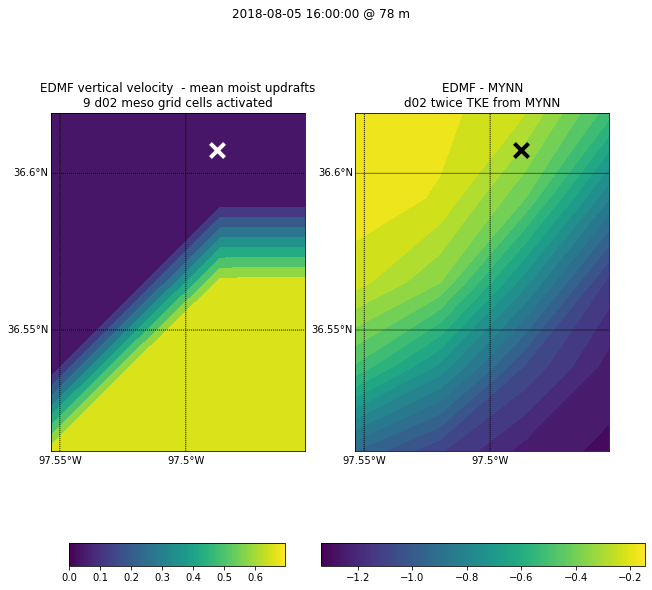

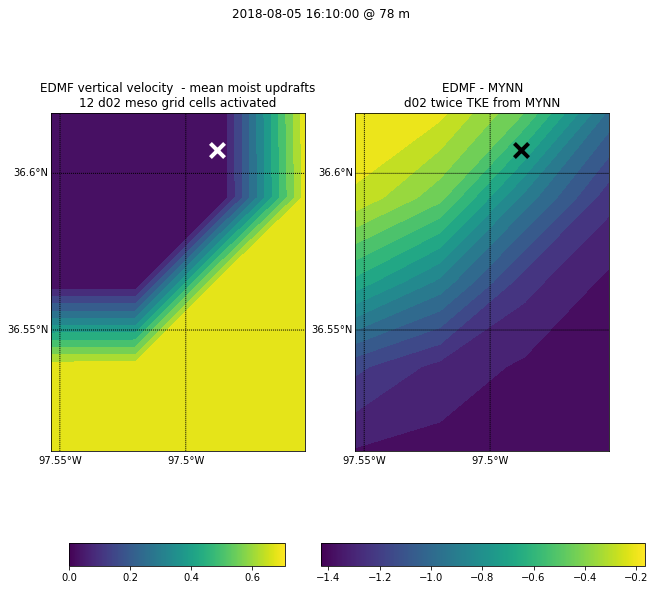

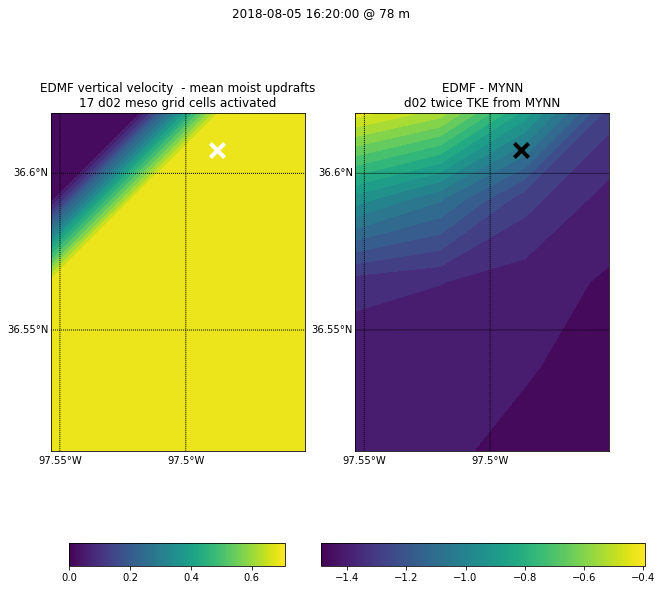

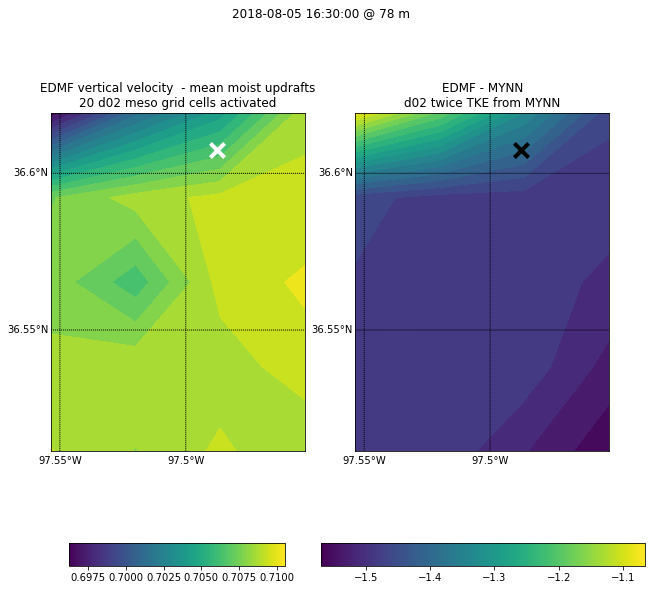

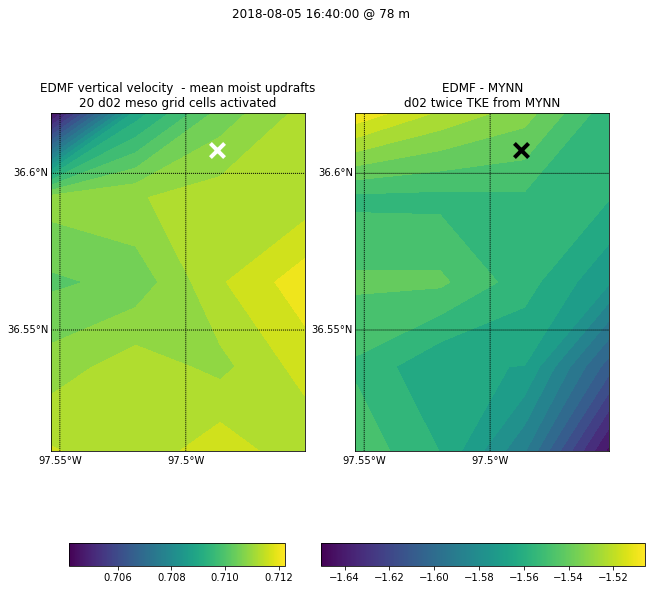

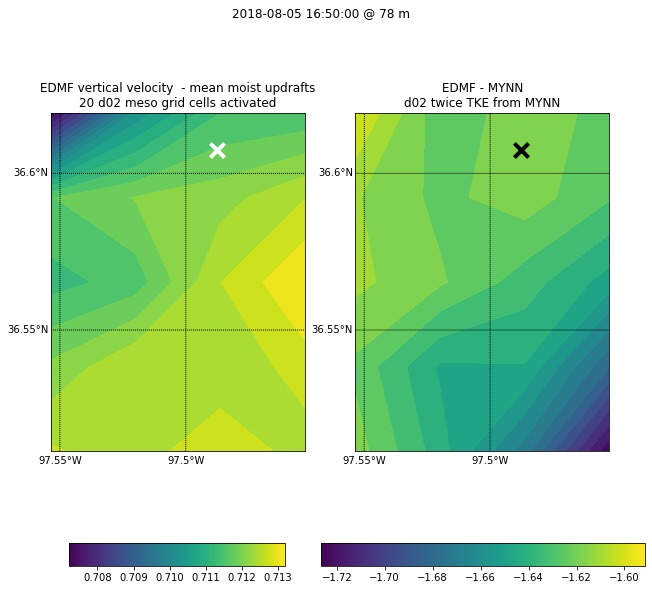

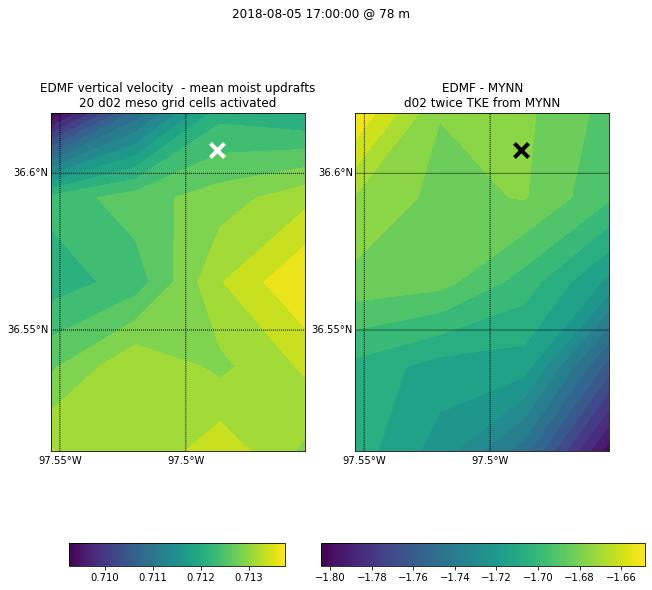

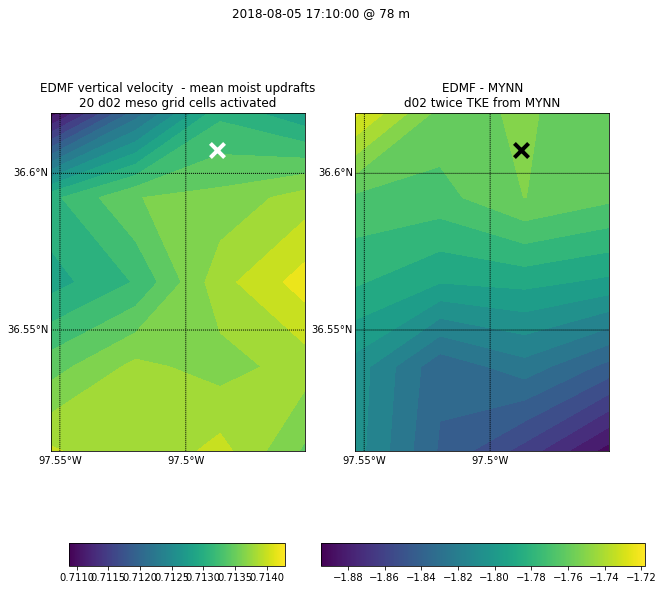

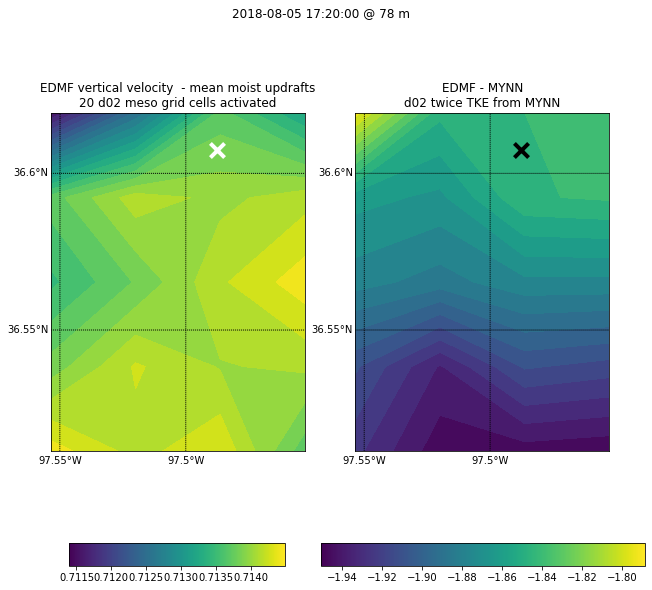

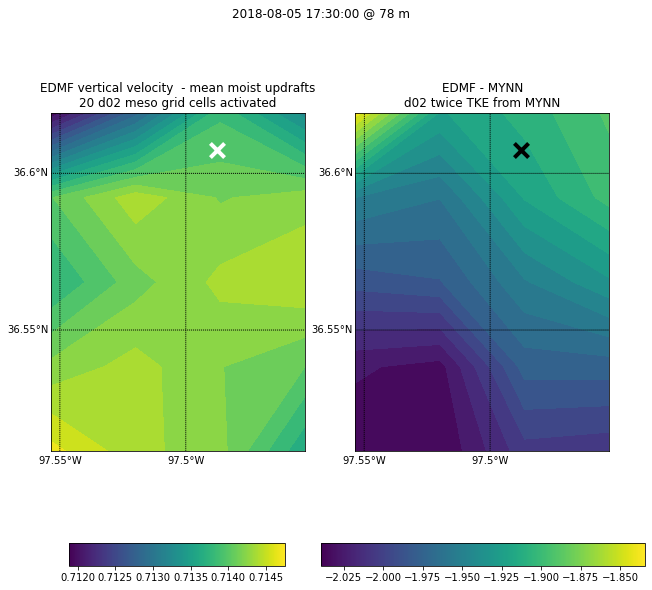

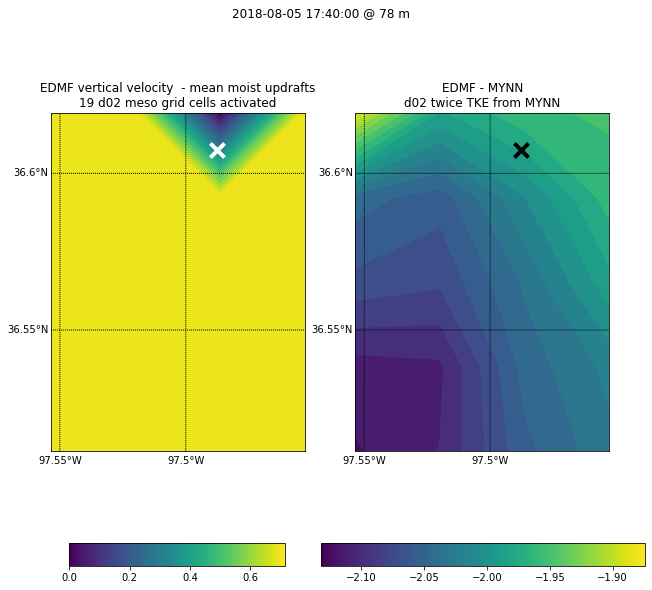

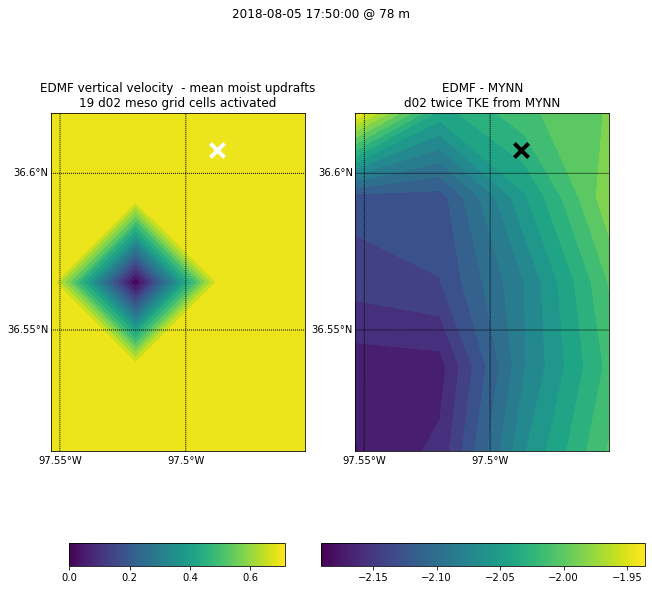

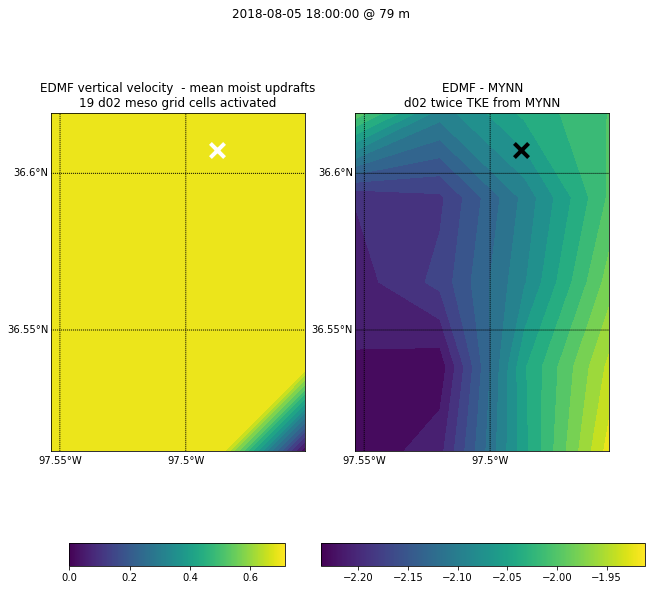

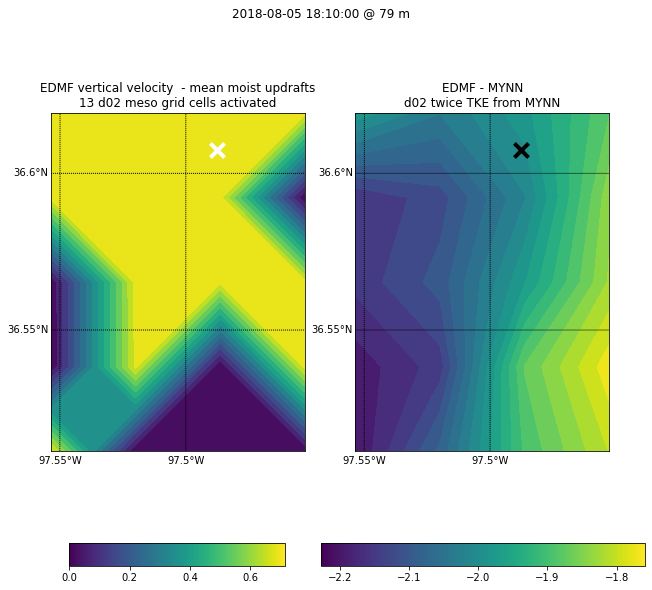

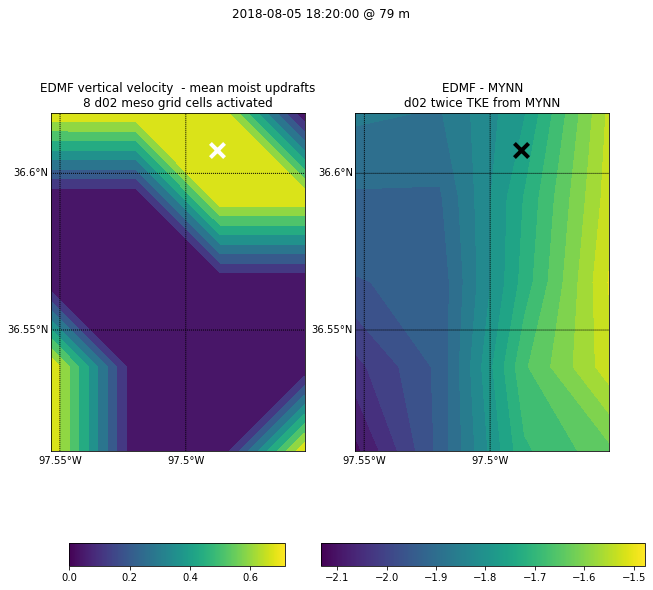

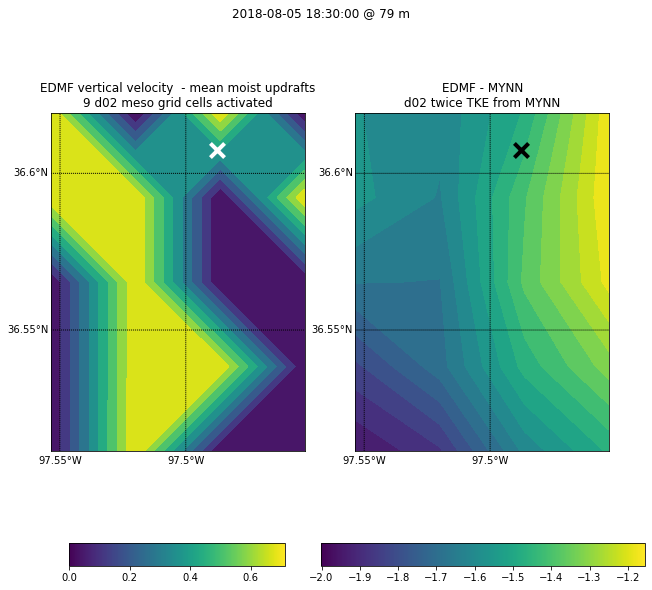

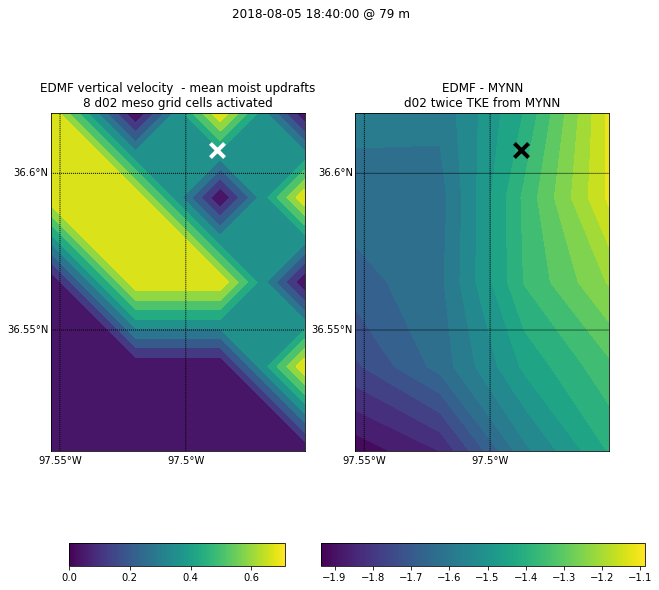

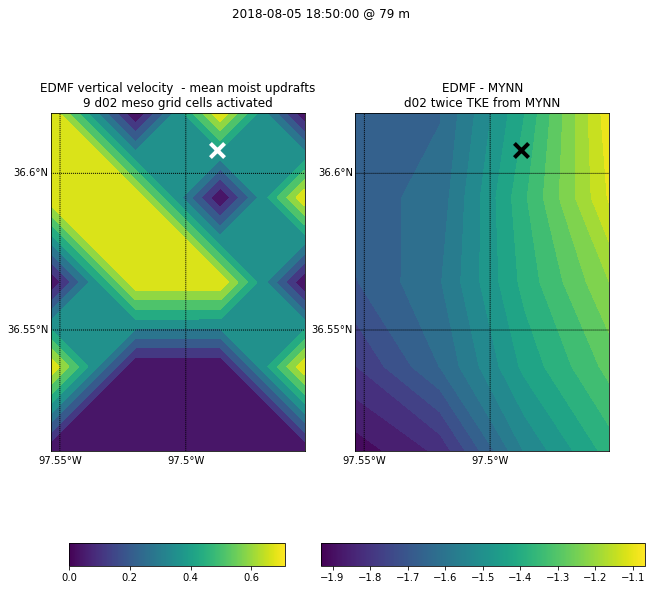

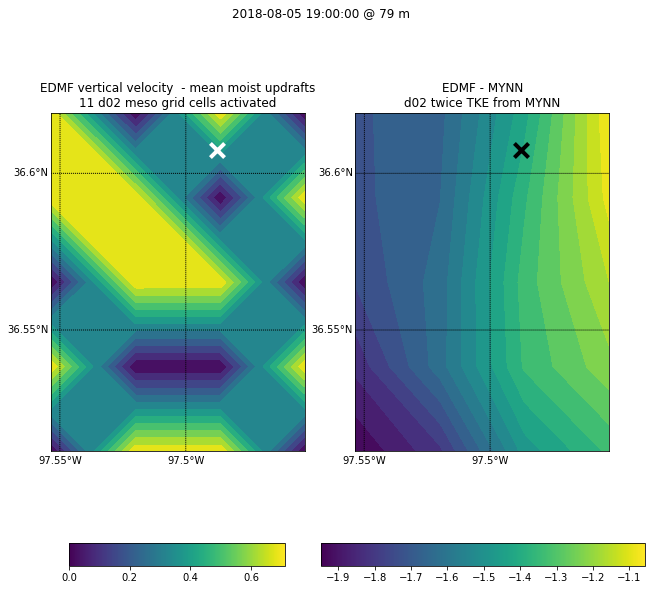

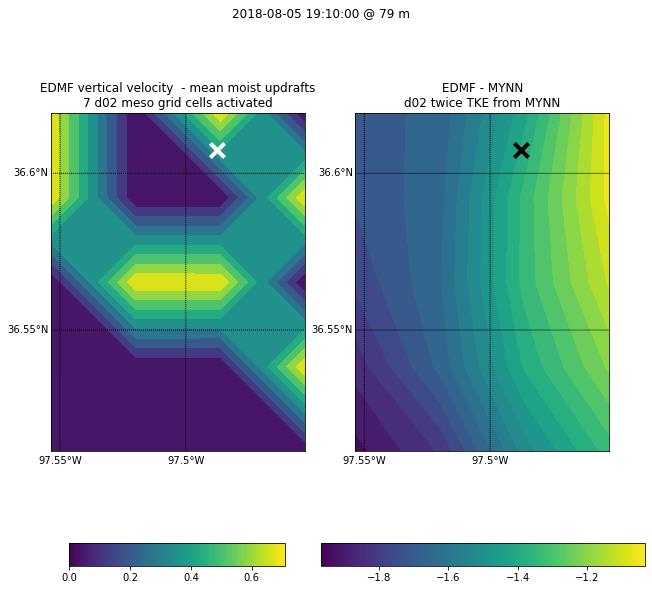

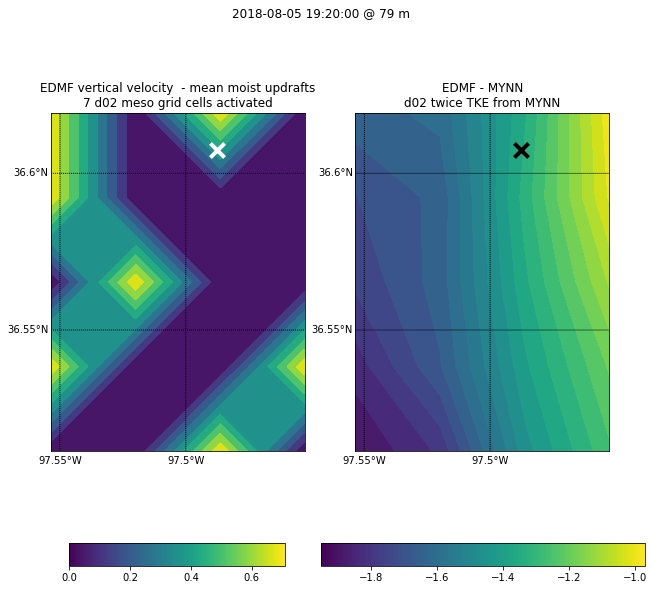

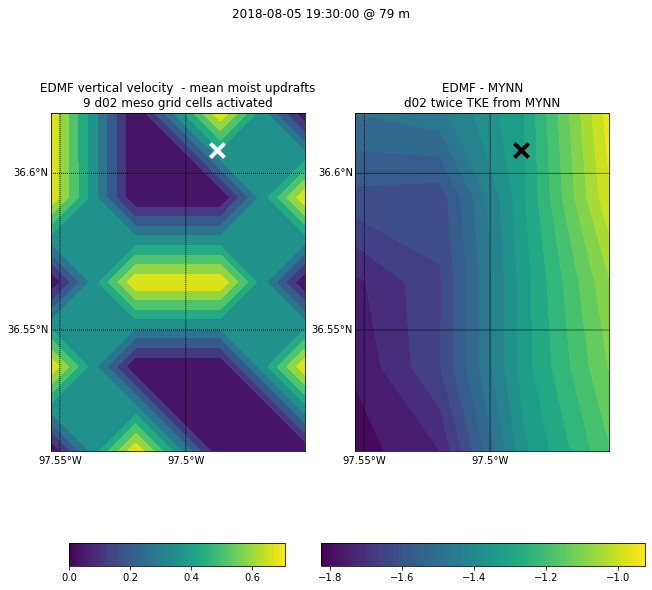

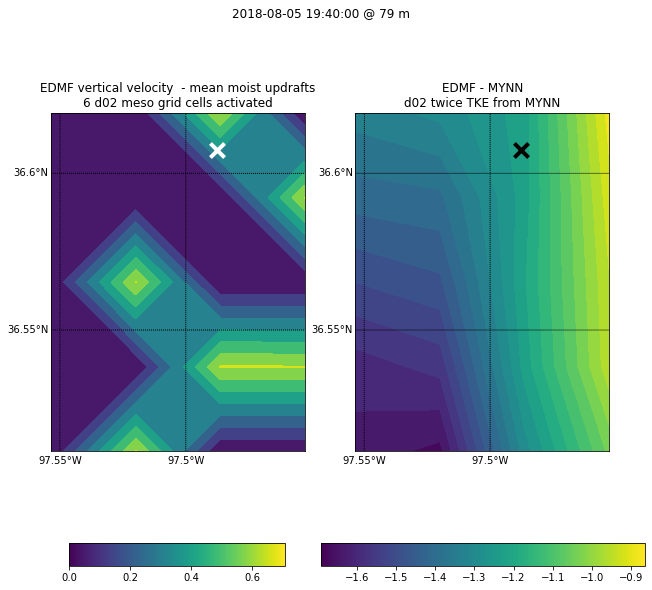

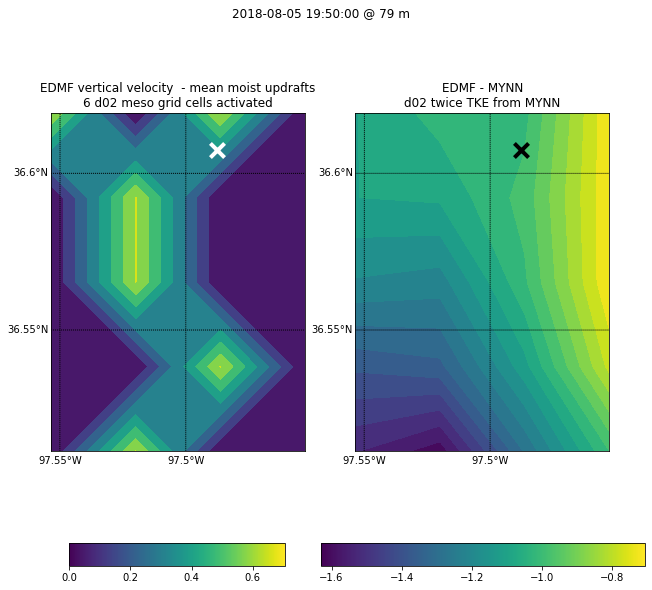

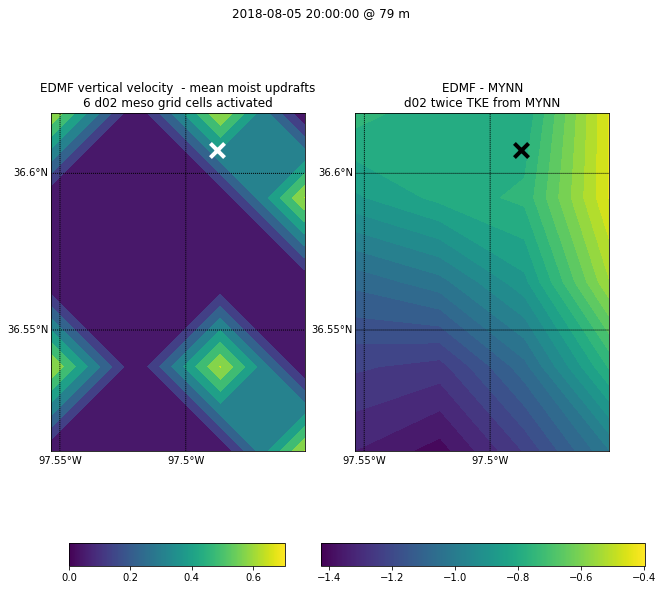

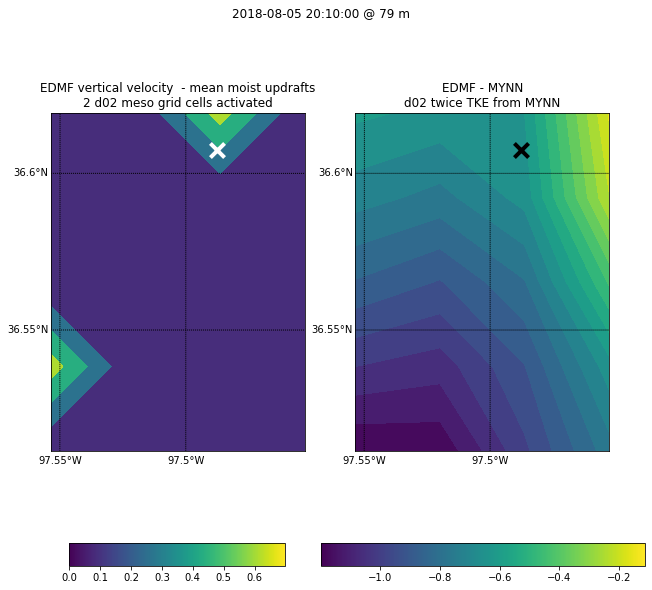

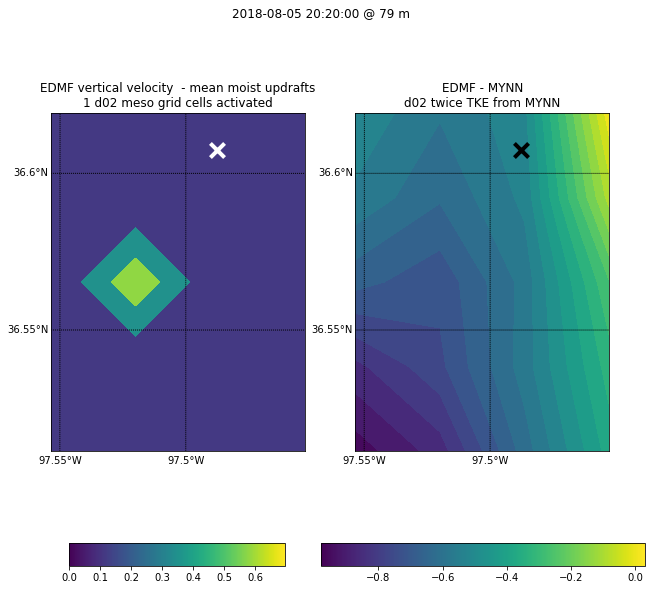

a total of 27 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20', '19:30', '19:40', '19:50', '20:0', '20:10', '20:20']


In [37]:
eval_date = '2018-08-05'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
d02var = 'QKE'
hgt_i = 16

detect_auxout_edmf_d02_plot_d02_vardiff(eval_date, run_e, run_m, edmf_var, d02var, hgt_i)

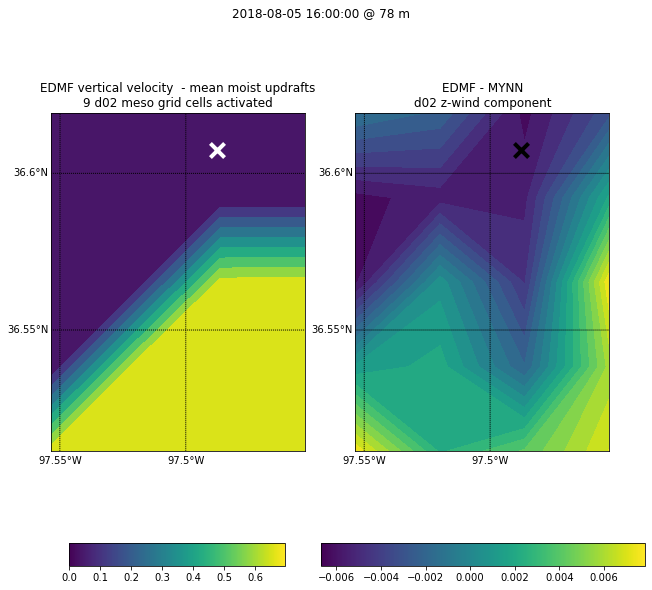

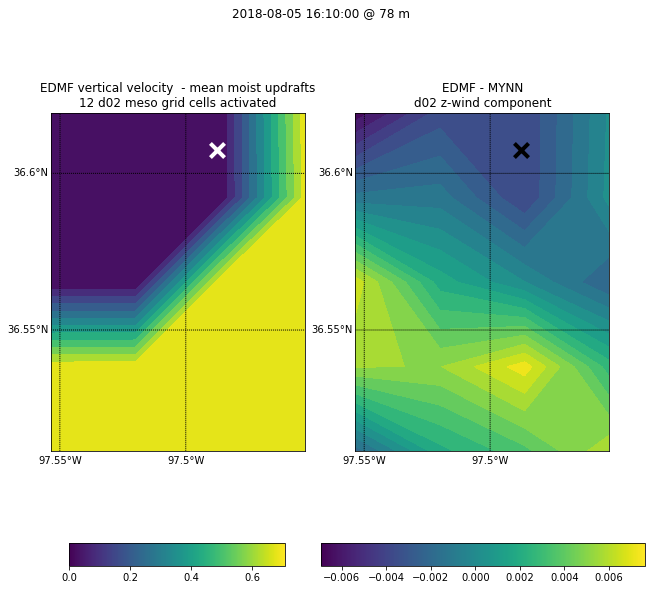

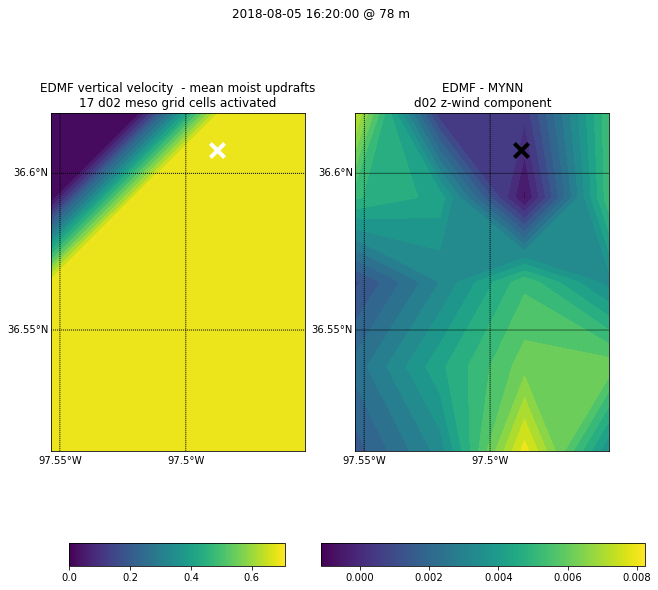

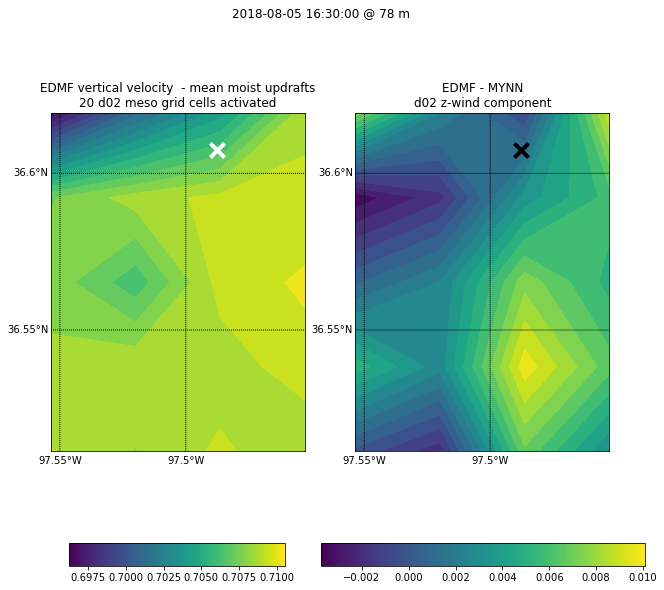

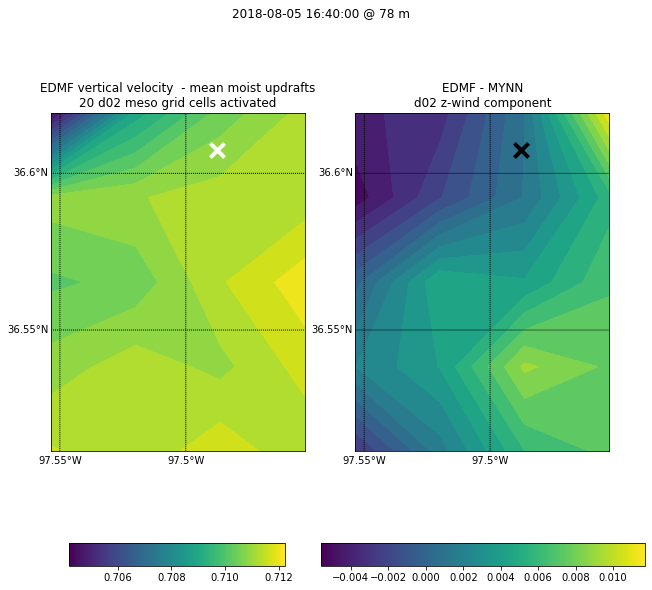

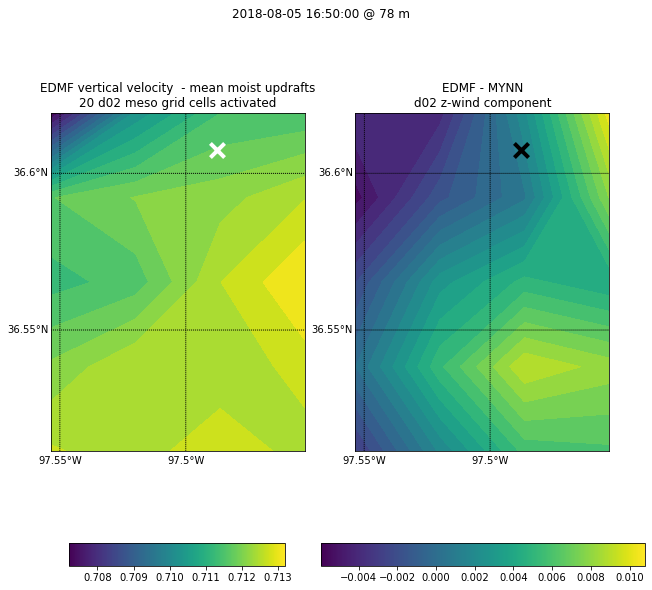

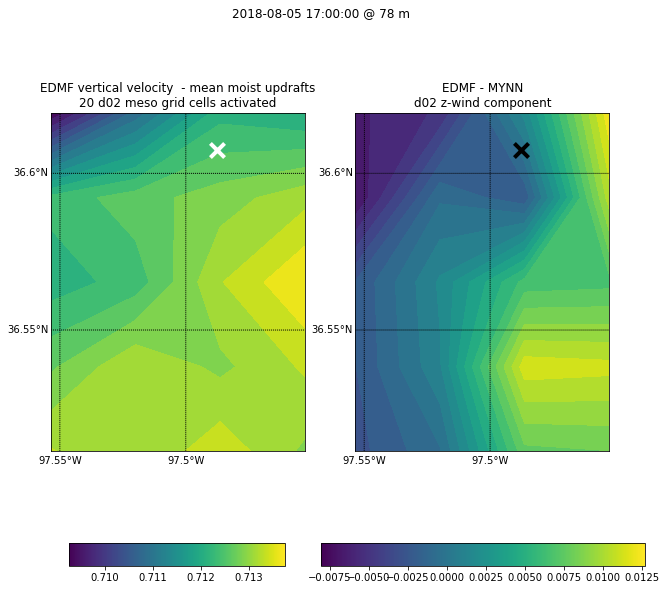

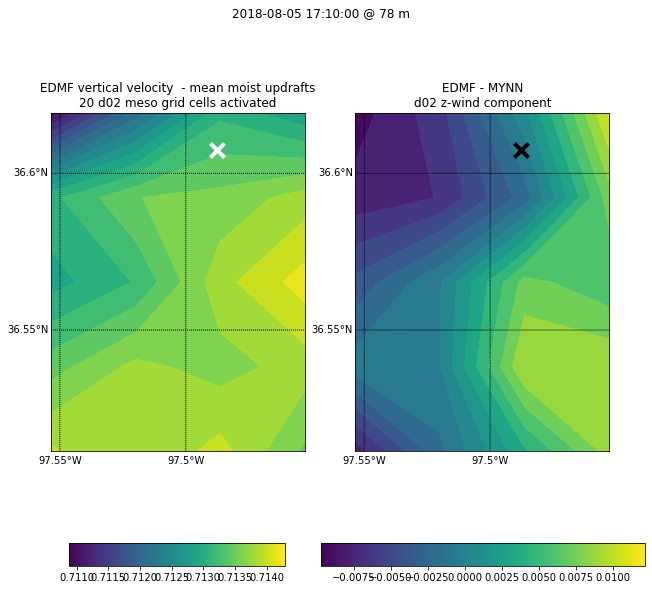

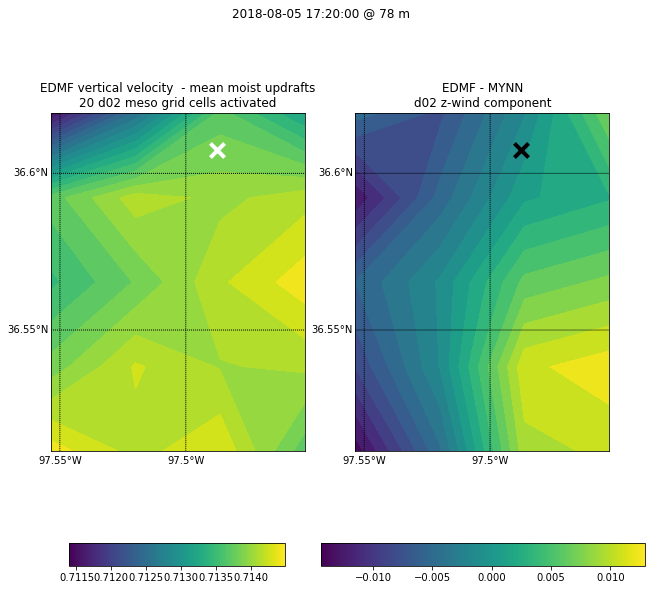

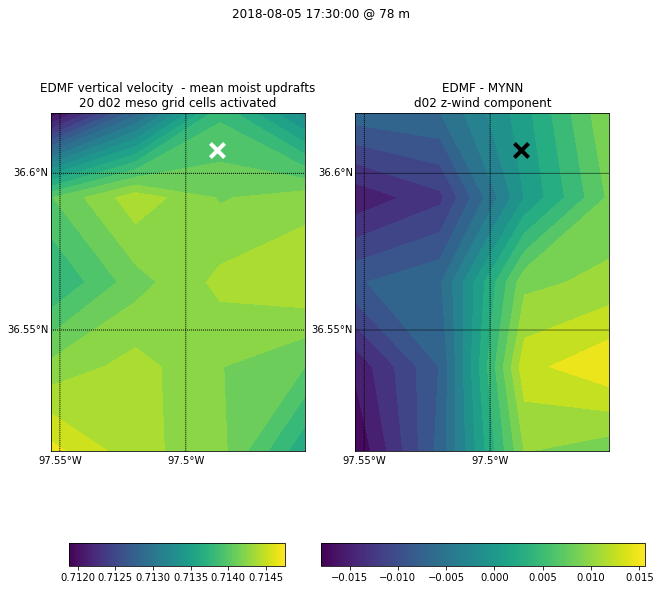

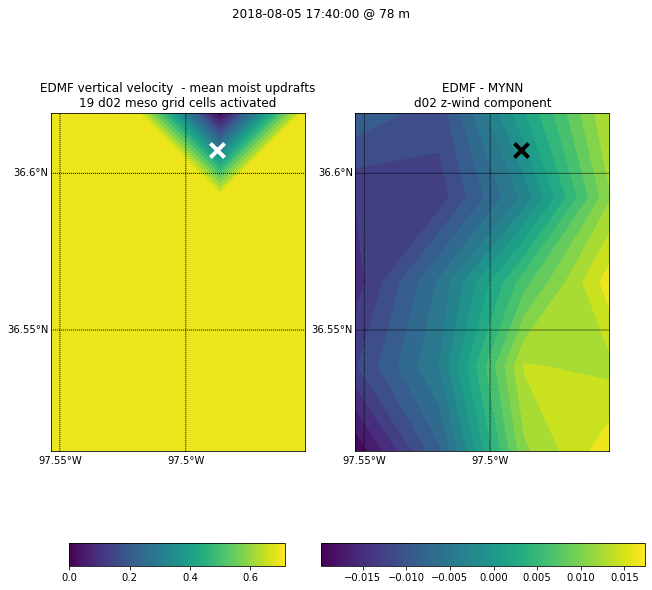

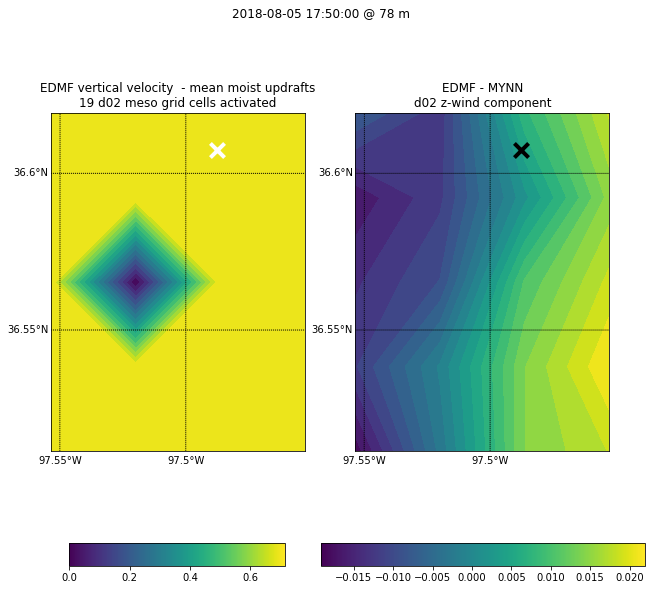

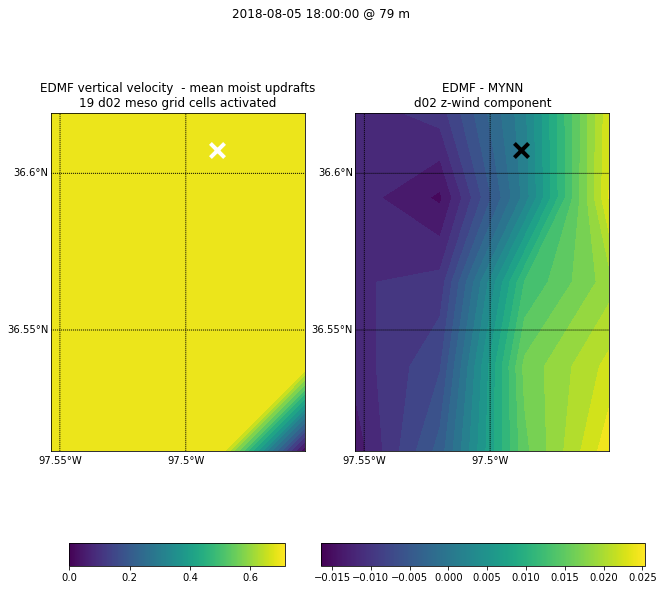

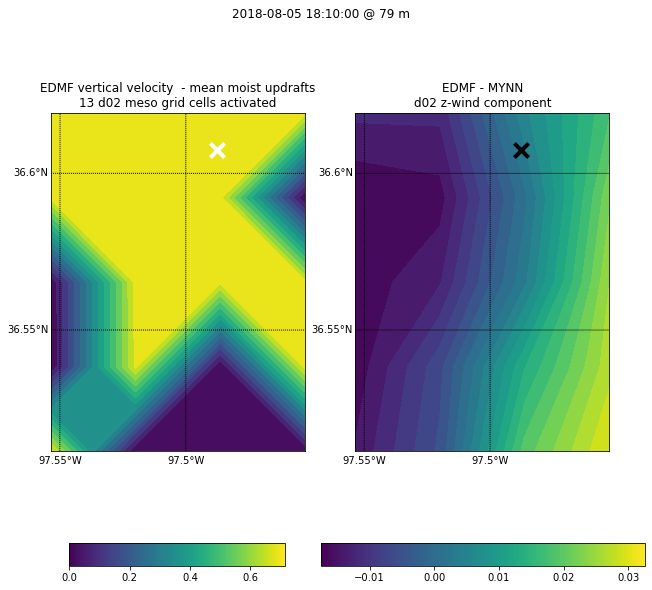

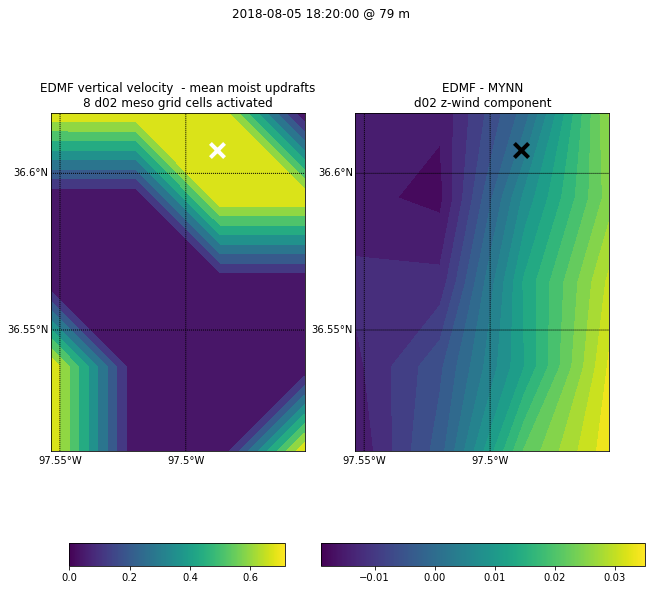

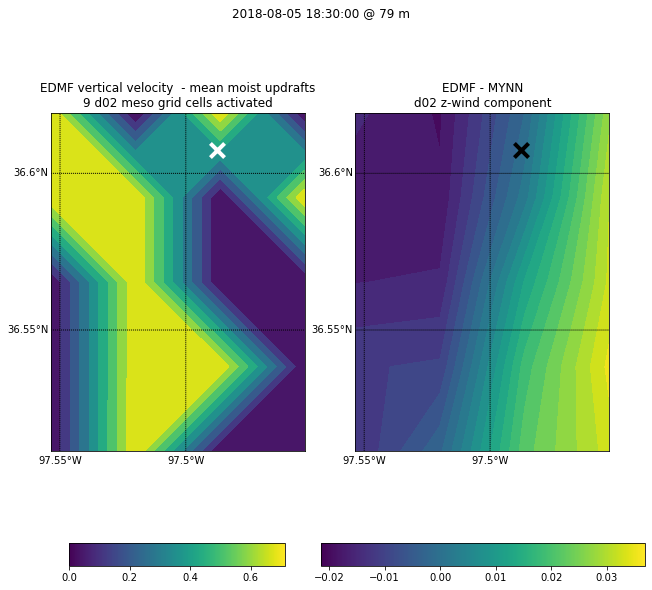

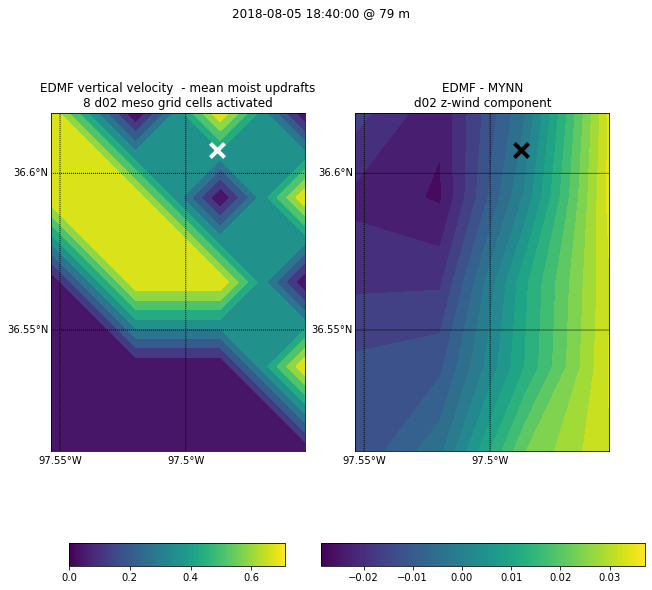

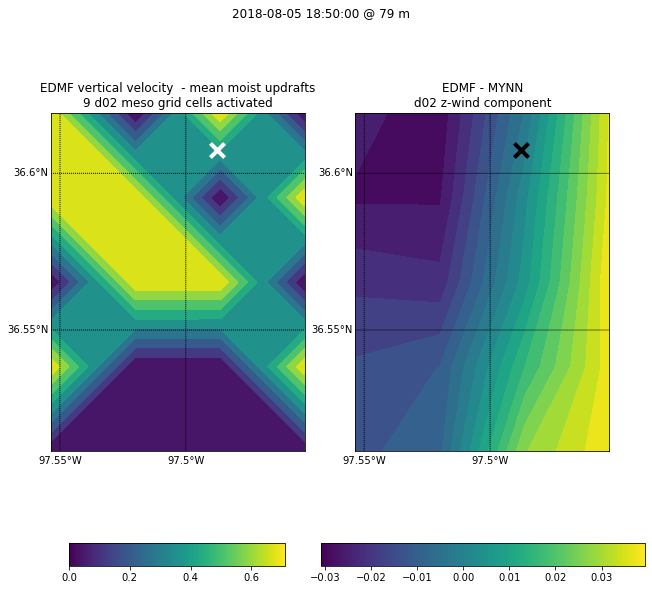

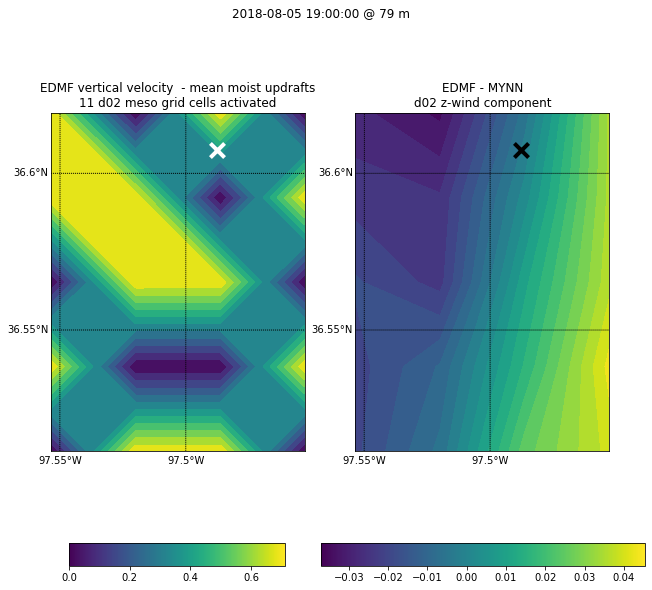

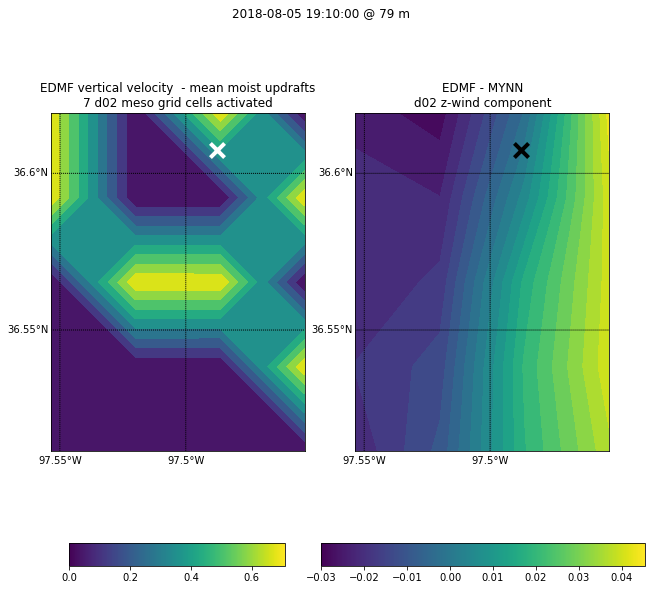

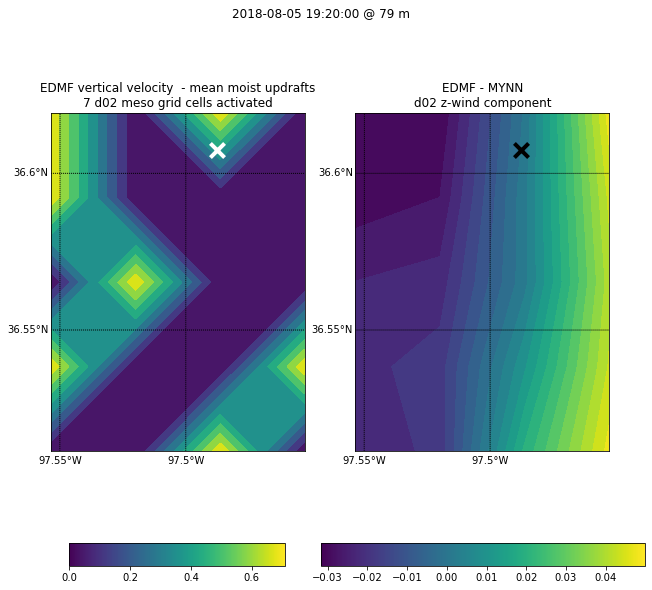

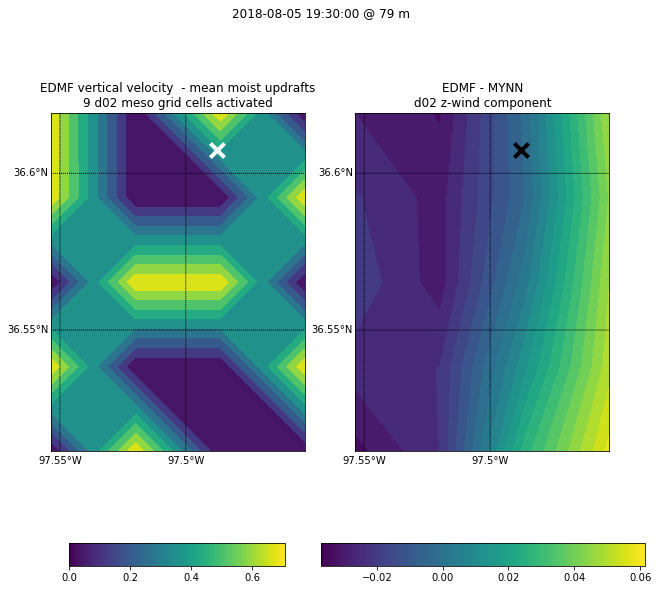

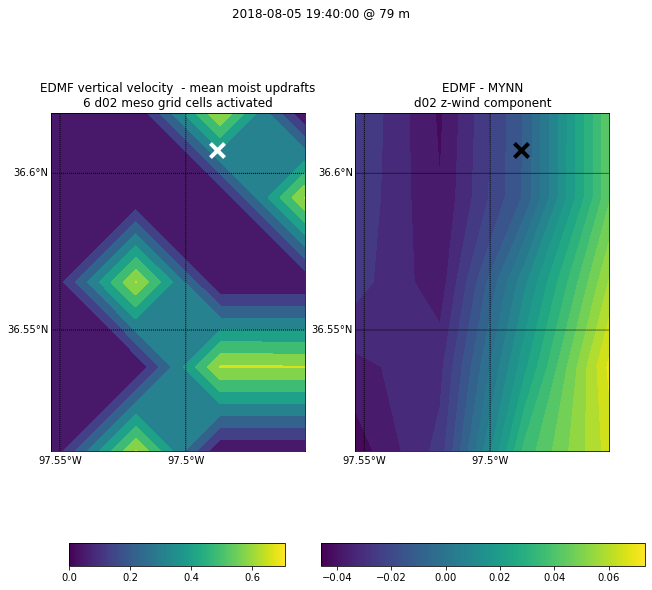

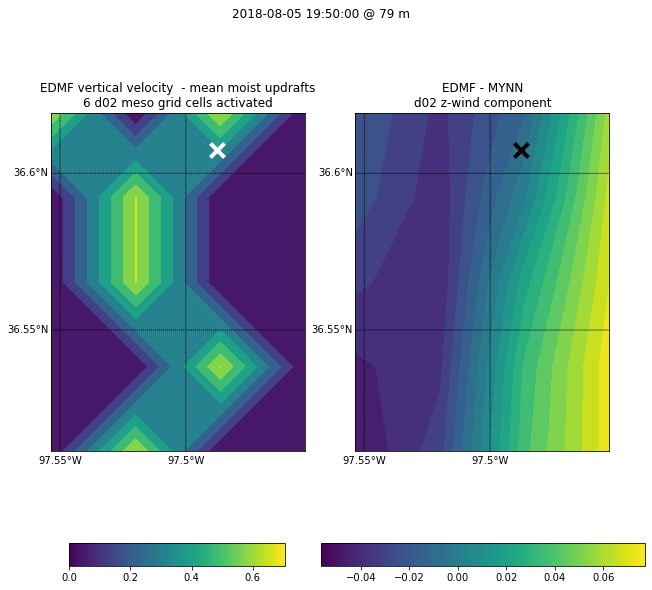

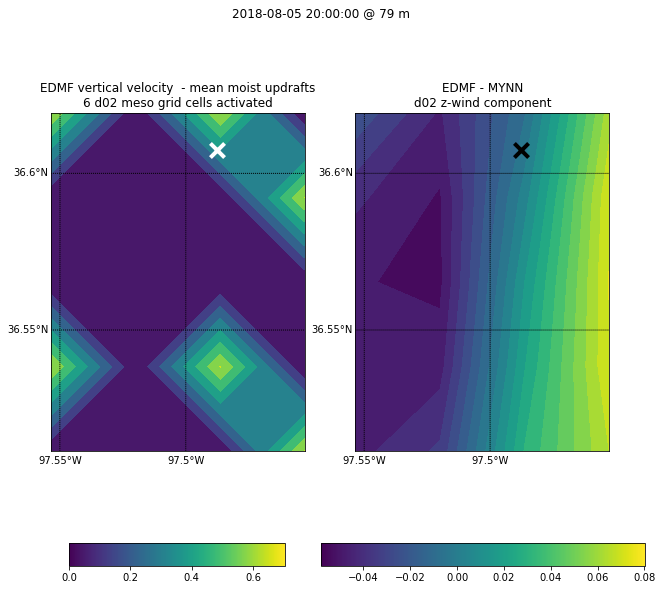

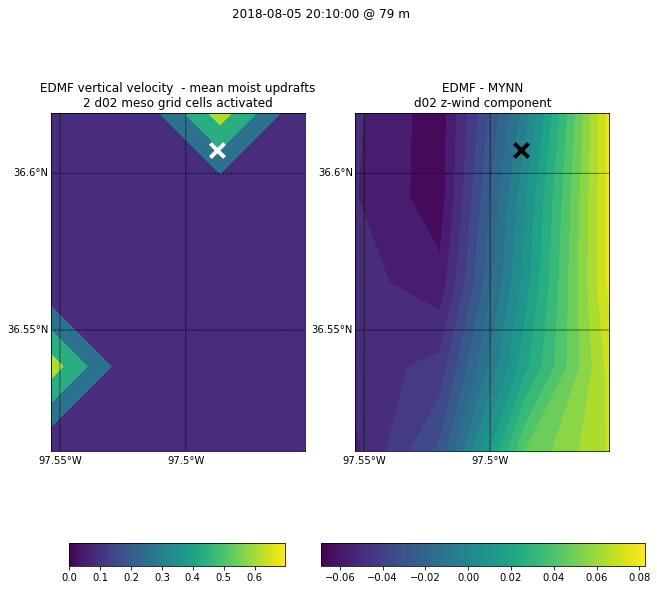

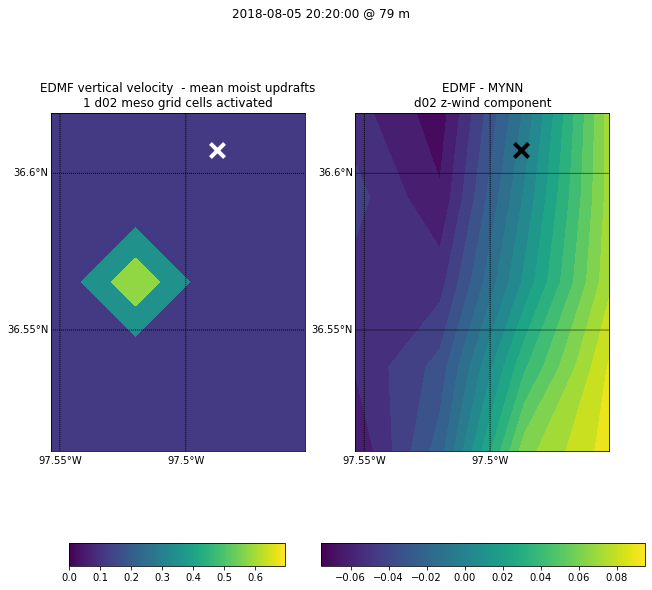

a total of 27 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20', '19:30', '19:40', '19:50', '20:0', '20:10', '20:20']


In [38]:
eval_date = '2018-08-05'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
d02var = 'W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d02_vardiff(eval_date, run_e, run_m, edmf_var, d02var, hgt_i)

In [3]:
def detect_auxout_edmf_d02_plot_d04_wdiff(eval_date, run_e, run_m, edmf_var, hgt_i, d04var='W'):

    date_col = data_dir_df[eval_date]

    activation_t = 0
    tstamp_list = []

    for hr in np.arange(16, 24, 1): 
    # hr = 17

        file = wrf_runs_dir+date_col[run_e]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')
        var = wrf.getvar(wrf_single, edmf_var, timeidx=wrf.ALL_TIMES)

        # d04 grid cells in d02
        var_edmfw = var[:, :, 121:126, 119:123]

        for t in np.arange(0, 6): 
#         for t in np.arange(0, 1): 

            if (var_edmfw[t, hgt_i, :, :] != 0).sum().values != 0:

                activation_t += 1

                file = wrf_runs_dir+date_col[run_e]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_e = wrf.getvar(wrf_single, d04var, timeidx=wrf.ALL_TIMES)
                
                if 'bottom_top_stag' in list(var_e.dims): 
                    w_e = wrf.destagger(var_e, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_e = var_e[:, hgt_i, :, :]
                    
                w_e = w_e.assign_coords(var_e.coords)

                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
                height_str = str(int(height.values))

                file = wrf_runs_dir+date_col[run_m]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':00:00'
                wrf_single = Dataset(file, 'r')
                var_m = wrf.getvar(wrf_single, d04var, timeidx=wrf.ALL_TIMES)
                
                if 'bottom_top_stag' in list(var_m.dims): 
                    w_m = wrf.destagger(var_m, 1, meta=True)[:, hgt_i, :, :]
                else:
                    w_m = var_m[:, hgt_i, :, :]
                
                w_m = w_m.assign_coords(var_m.coords)

                var_wdiff = w_e - w_m

                var_wdiff = var_wdiff.assign_coords(w_e.coords)
                var_wdiff = var_wdiff.assign_attrs(w_e.attrs)

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

                ###

                var_1time1hgt = var_edmfw[t, hgt_i, :, :]

                bm = wrf.get_basemap(var_1time1hgt, ax=ax1)

                bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                lats, lons = wrf.latlon_coords(var_edmfw)

                x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

                p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                levels=len(np.unique(var_1time1hgt.values)))

                tstamp = pd.Timestamp(var_edmfw[t, :, :, :].Time.values)
                tstamp_list.append(str(tstamp.hour)+':'+str(tstamp.minute))

                ax1.set_title(var_1time1hgt.description+'\n'
                             +str((var_edmfw[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

                c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax1)

                c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
        #         ax1.annotate('C1', xy=(c1x, c1y), size=15, color='white')

                cax = plt.axes([0.15, 0.01, 0.3, 0.04])
                sm = plt.cm.ScalarMappable(cmap='viridis', 
                                           norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                ###

                var_1time1hgt = var_wdiff[t, :, :]

                v_min = var_1time1hgt.min()
                v_max = var_1time1hgt.max()

                orig_cmap = matplotlib.cm.coolwarm
                shrunk_cmap = shiftedColorMap(orig_cmap, midpoint=1-(v_max/(v_max+abs(v_min))), name='shrunk')

                bm = wrf.get_basemap(var_1time1hgt, ax=ax2)

                bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                lats, lons = wrf.latlon_coords(var_wdiff)

                x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

        #         p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
        #                         levels=len(np.unique(var_1time1hgt.values)))
                p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=shrunk_cmap)

                ax2.set_title('EDMF - MYNN\nd04 '+var_1time1hgt.description)

                c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                bm.scatter(c1x, c1y, s=200, marker='x', color='black', linewidth=4, ax=ax2)

                c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
        #         ax2.annotate('C1', xy=(c1x, c1y), size=15, color='black')

                cax = plt.axes([0.5, 0.01, 0.45, 0.04])
                sm = plt.cm.ScalarMappable(cmap=shrunk_cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
                cb = plt.colorbar(sm, cax=cax, orientation='horizontal', label='['+var_wdiff.units+']')

                plt.suptitle(str(tstamp)+' @ '+height_str+' m')

                plt.show()

    print('a total of', activation_t, 'time steps w/ EDMF turned on in d02, they are:')
    print(tstamp_list)

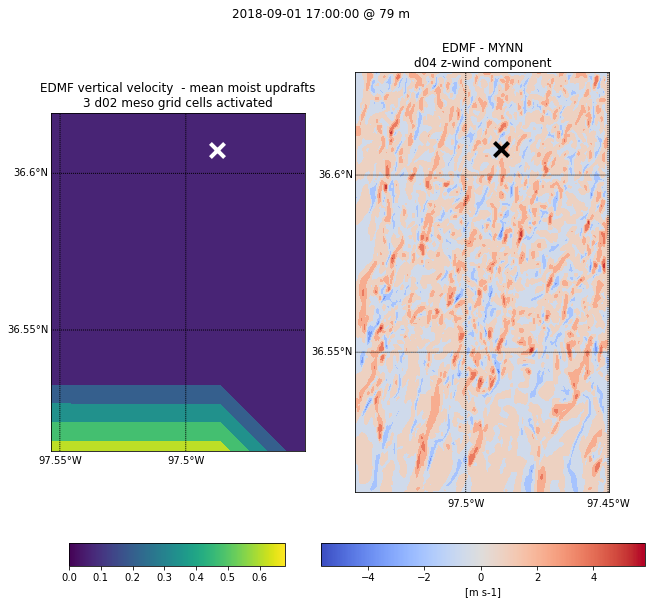

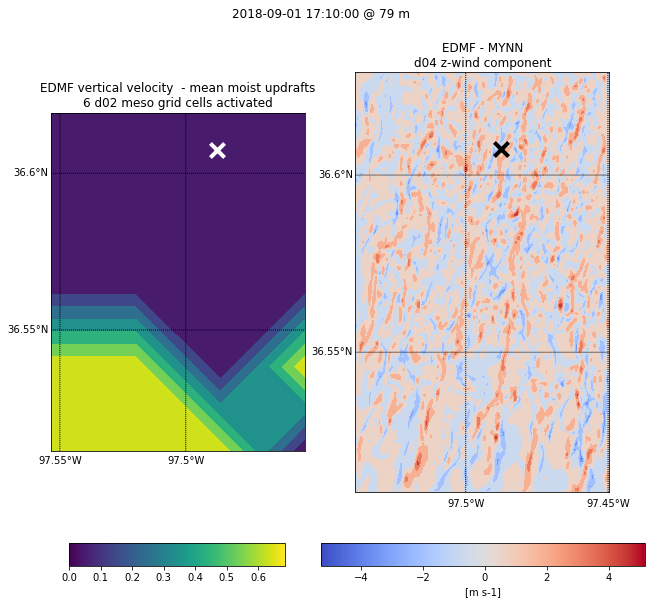

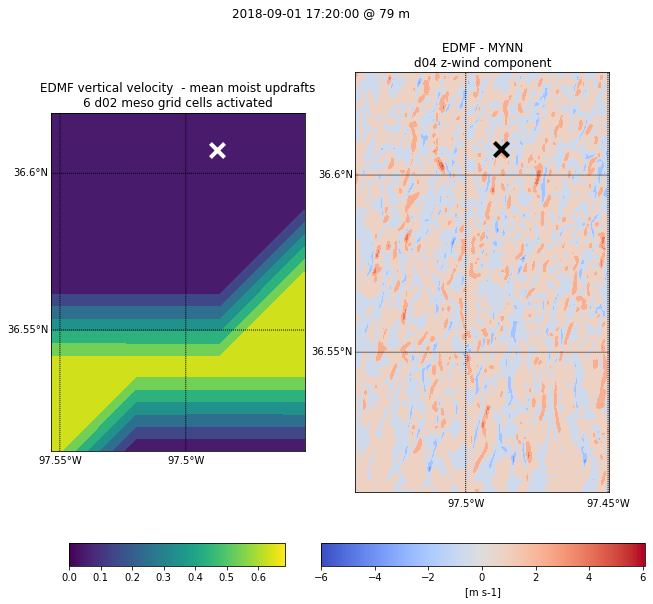

a total of 3 time steps w/ EDMF turned on in d02, they are:
['17:0', '17:10', '17:20']


In [4]:
eval_date = '2018-09-01'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
# d04var = 'W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04_wdiff(eval_date, run_e, run_m, edmf_var, hgt_i)

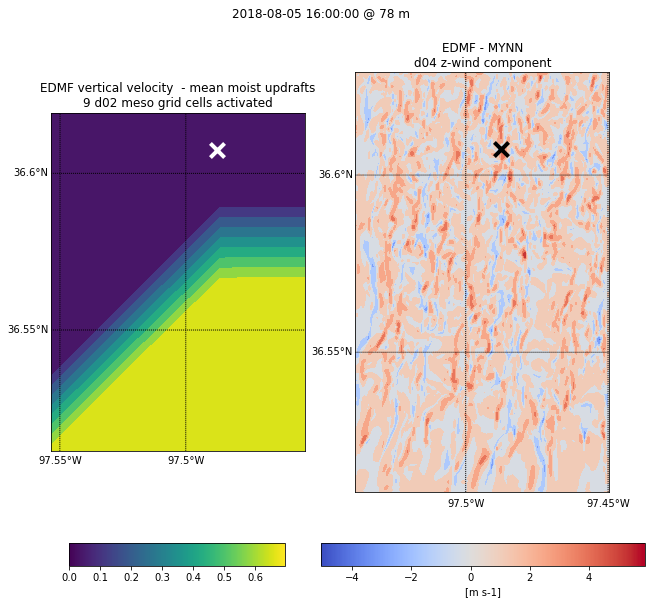

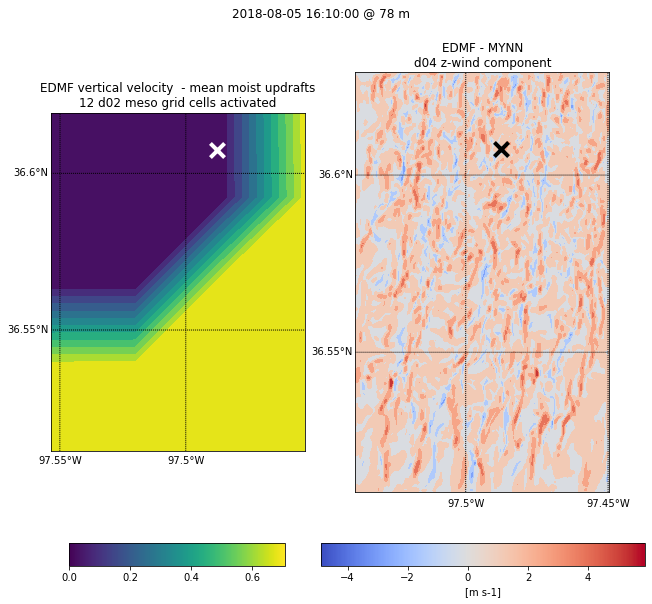

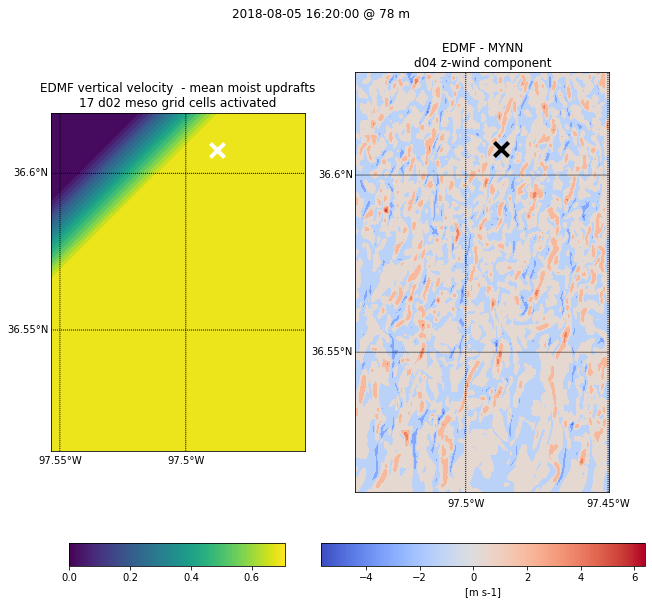

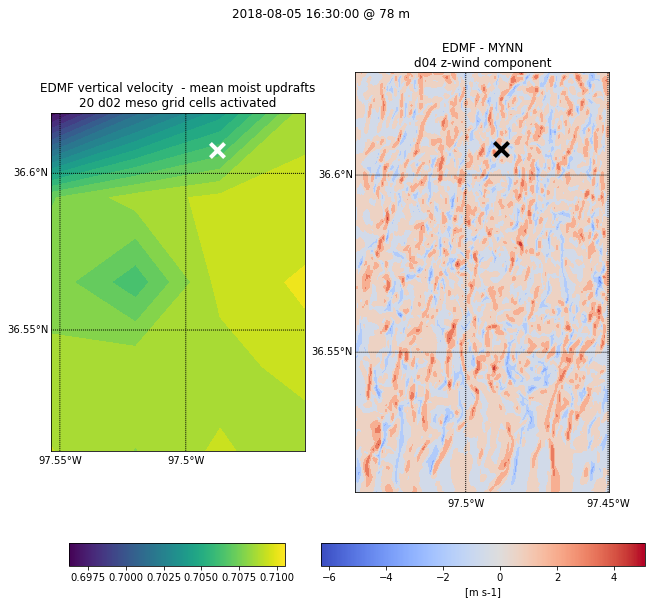

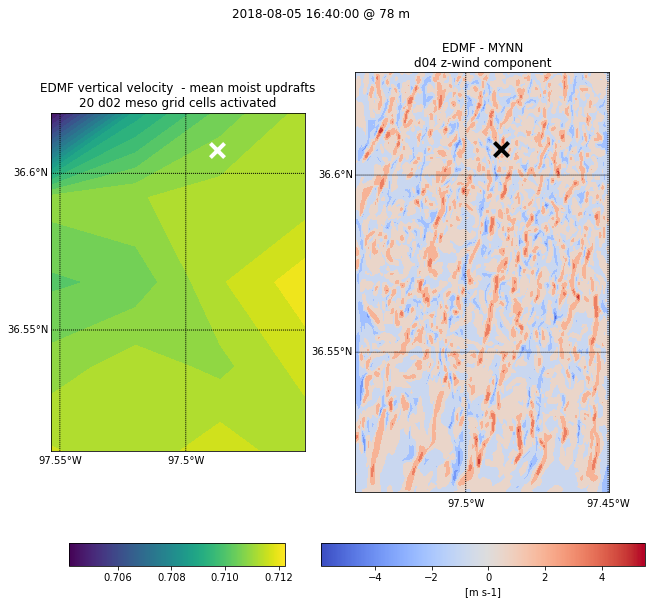

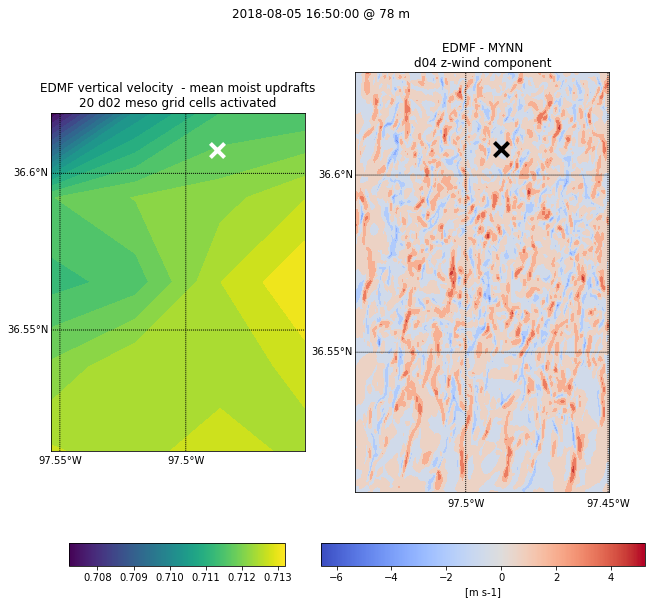

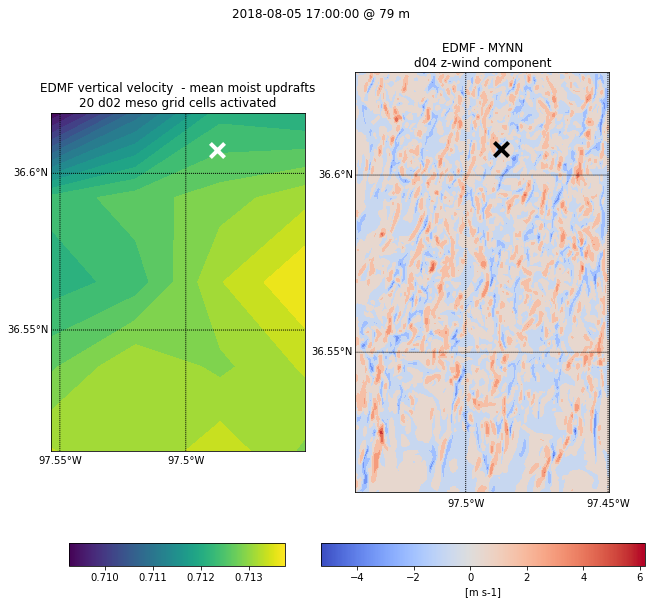

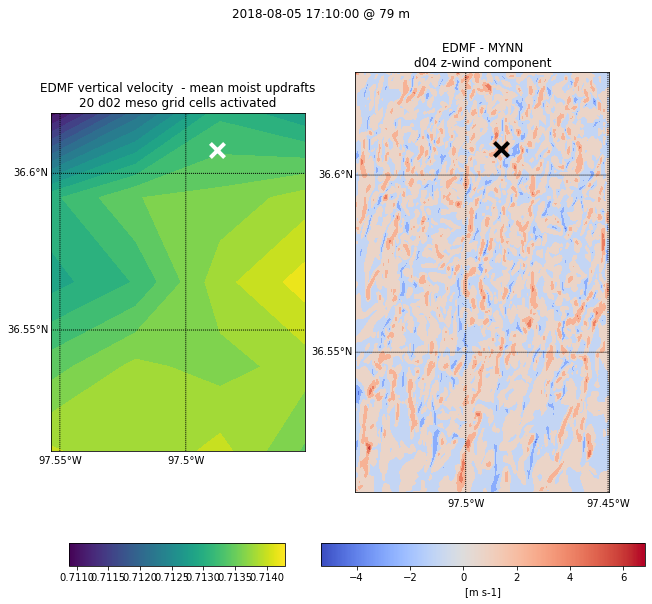

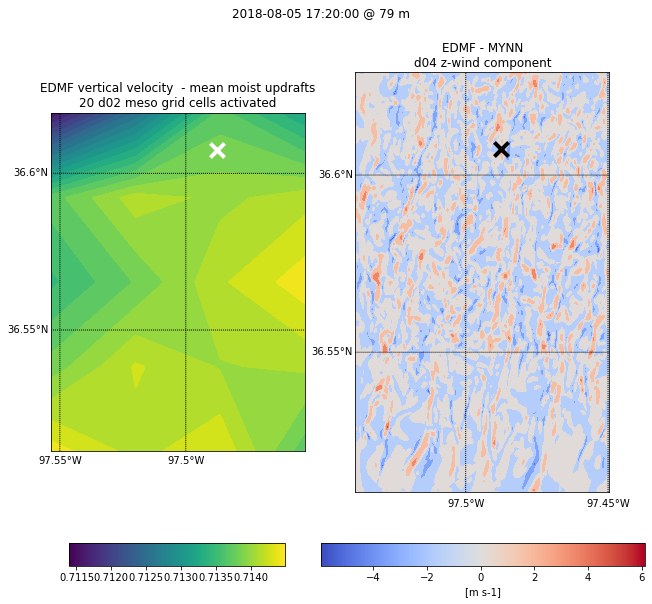

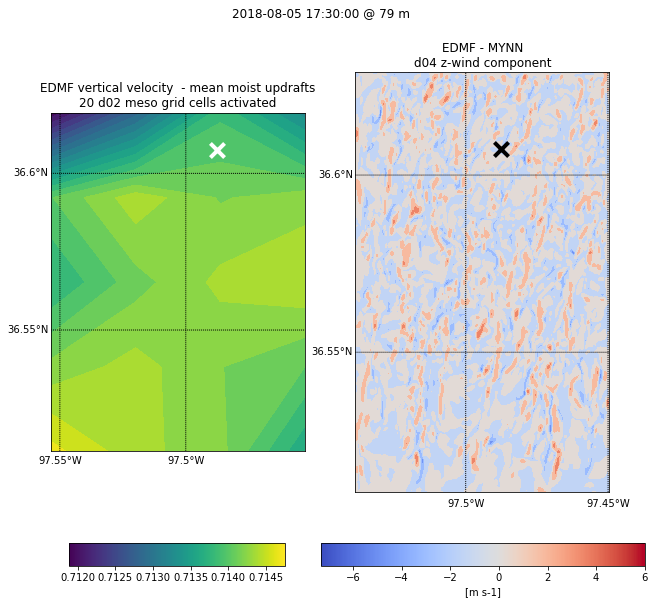

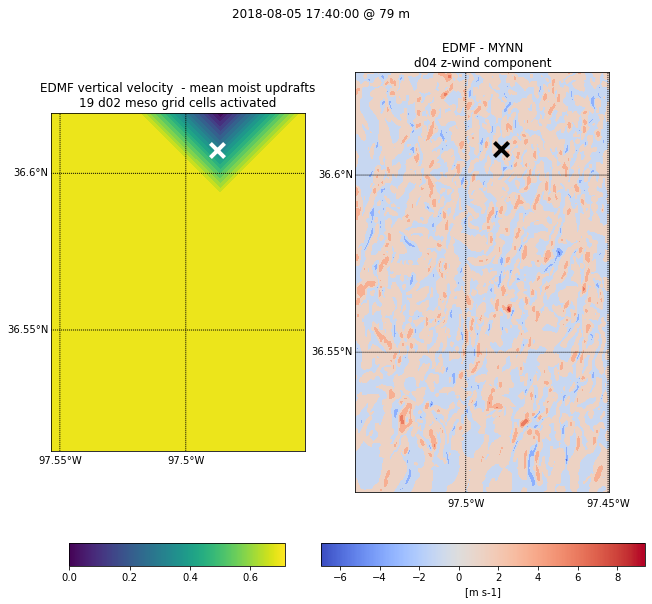

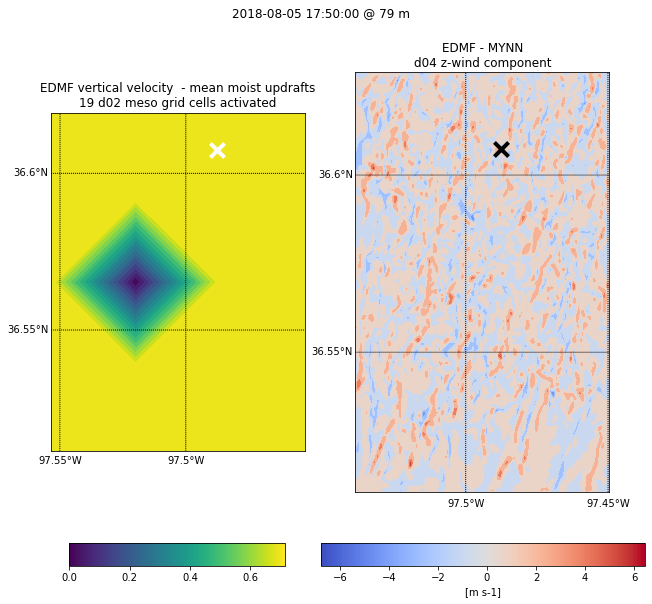

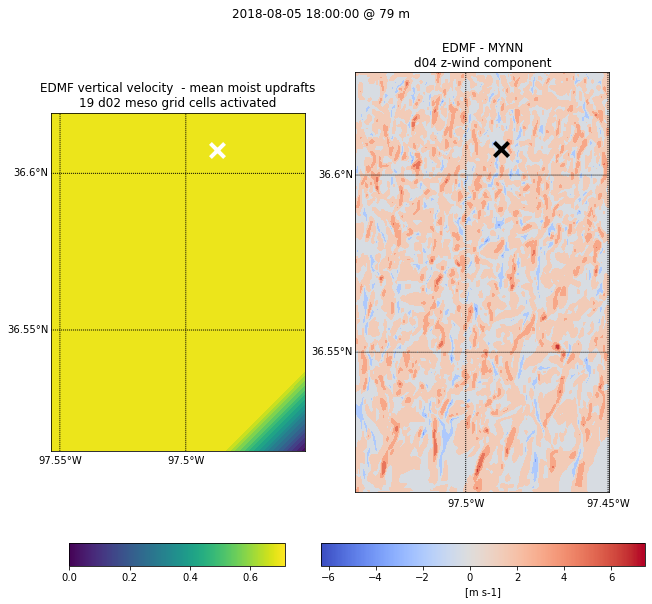

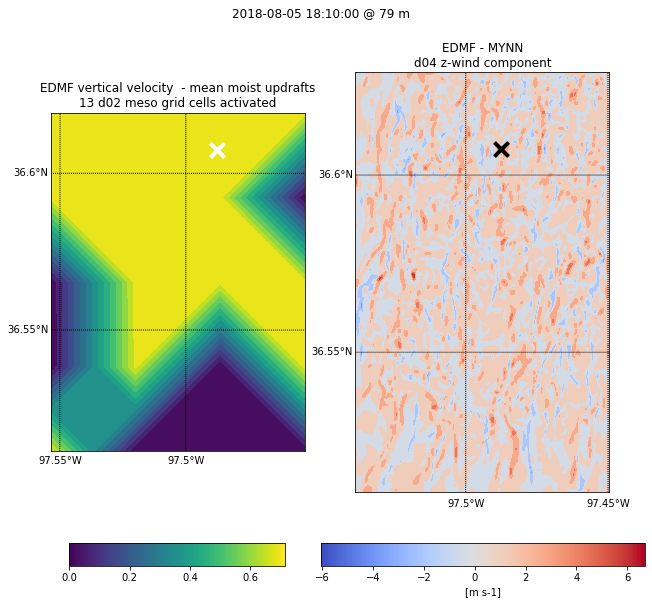

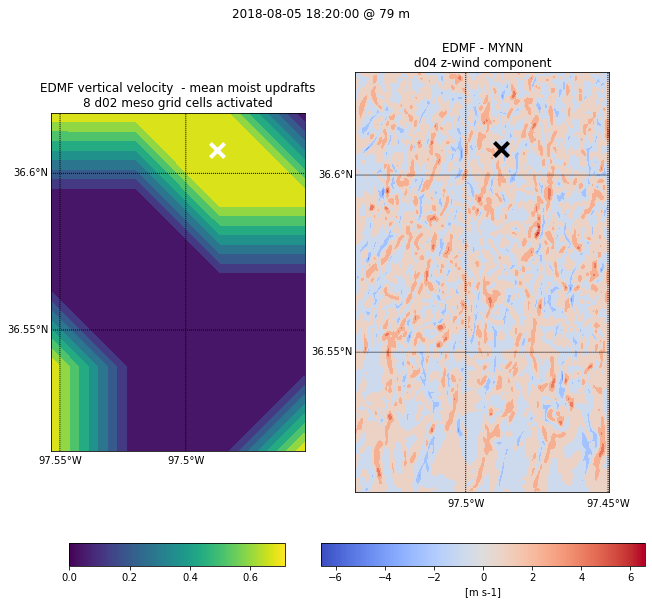

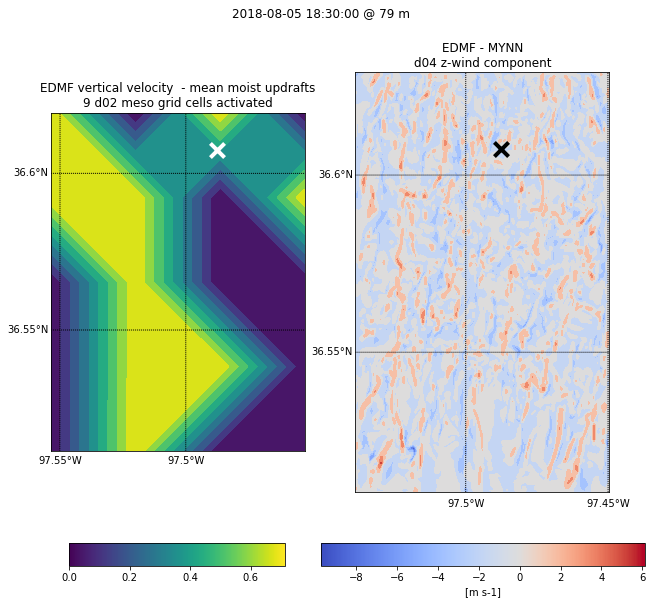

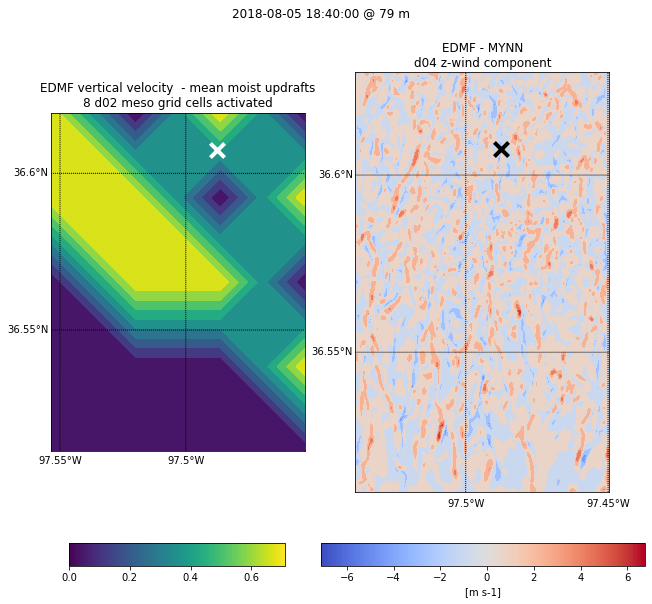

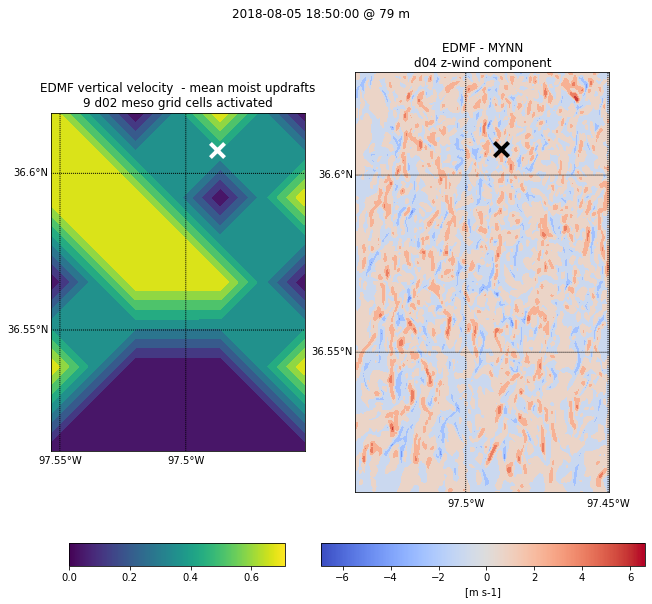

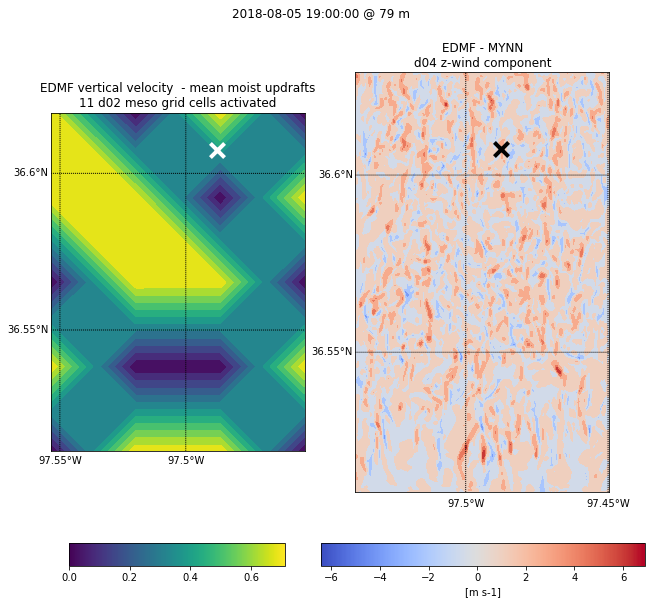

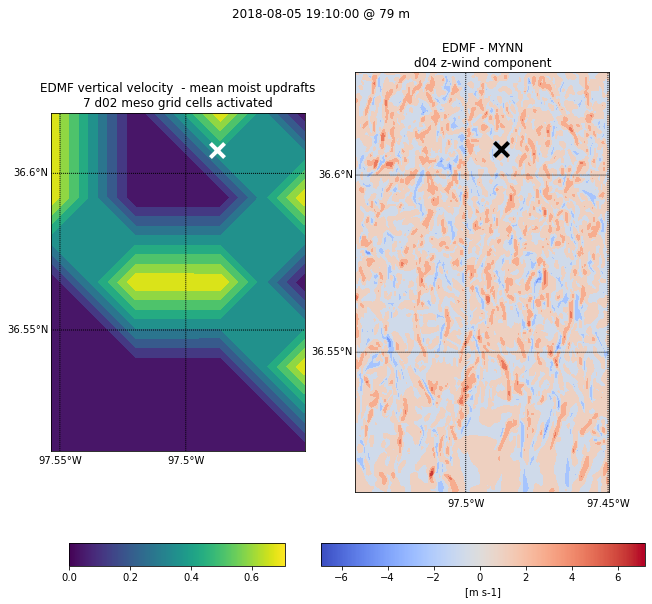

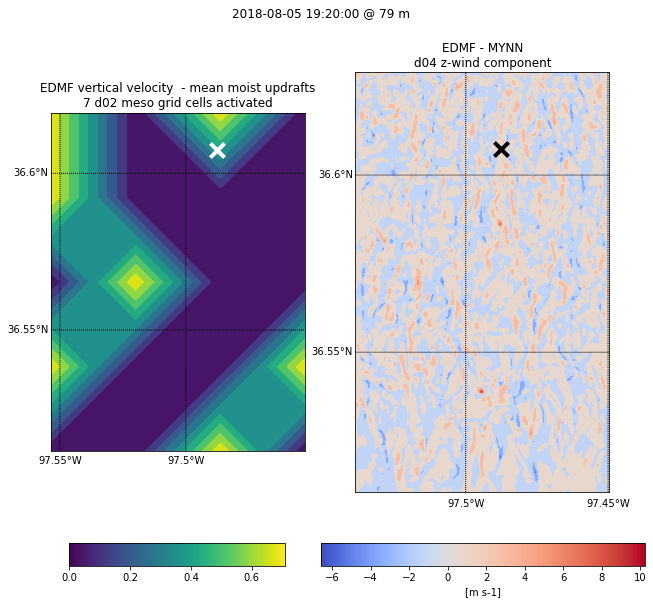

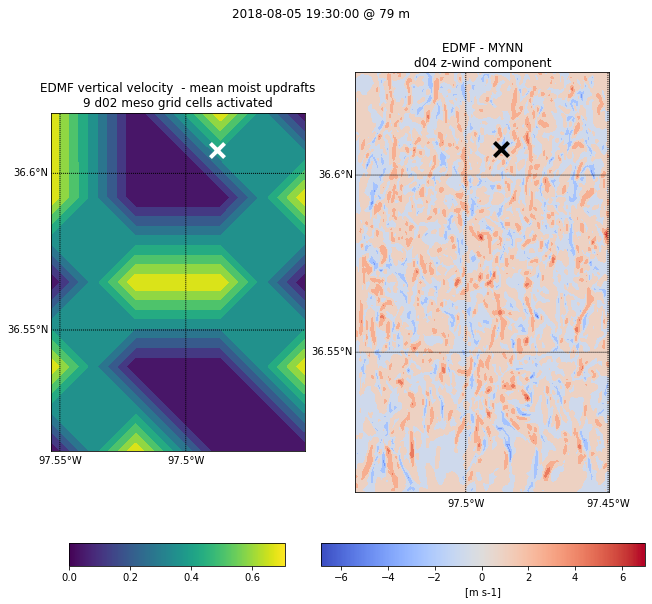

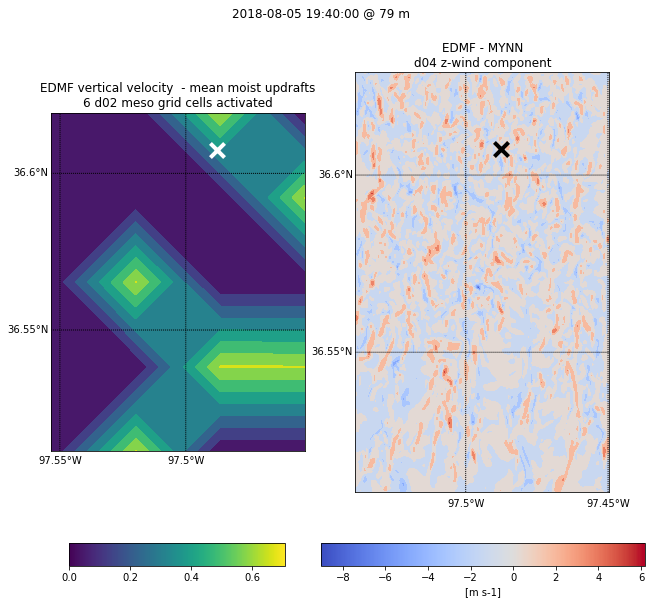

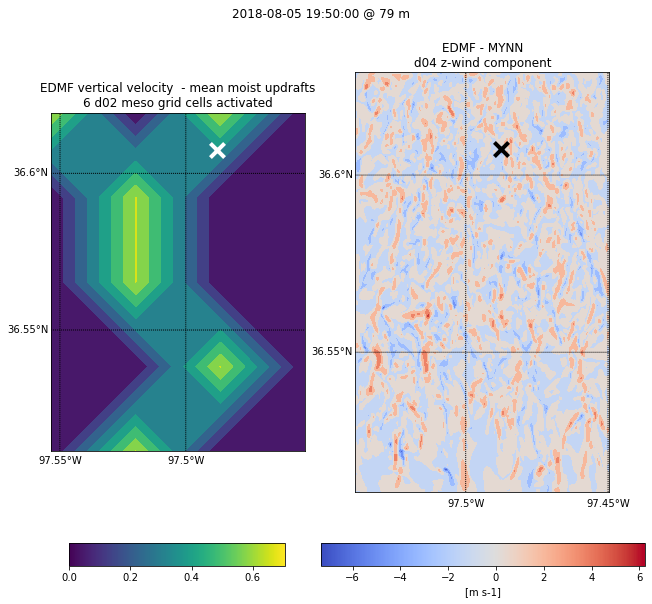

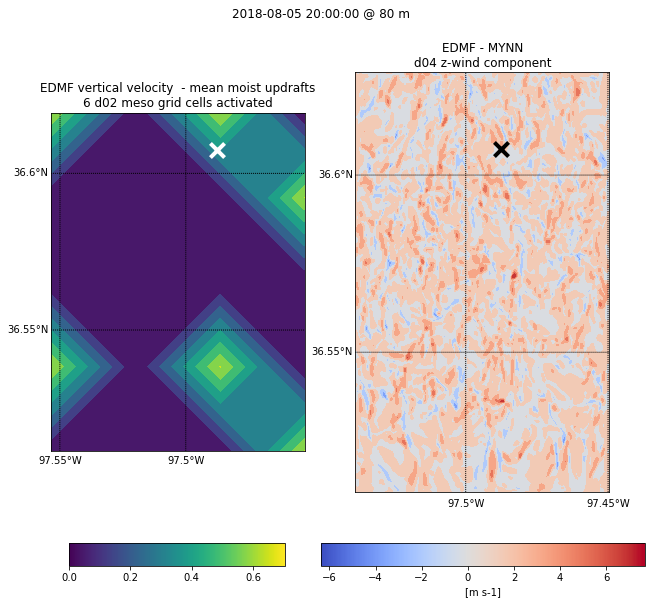

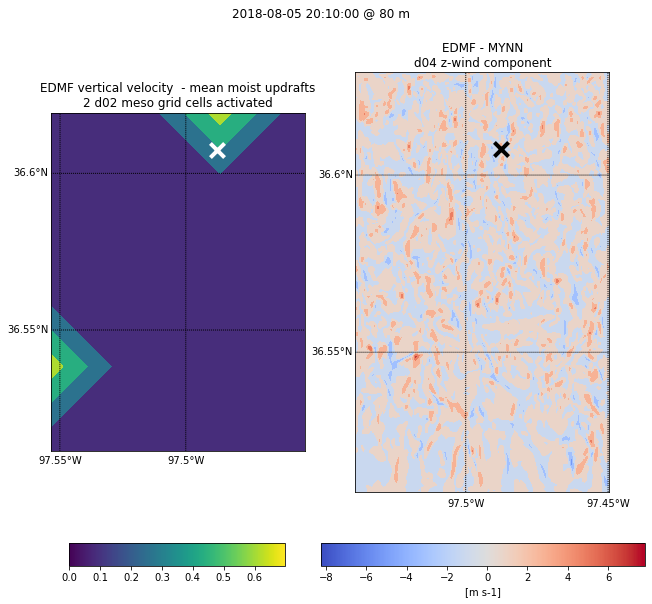

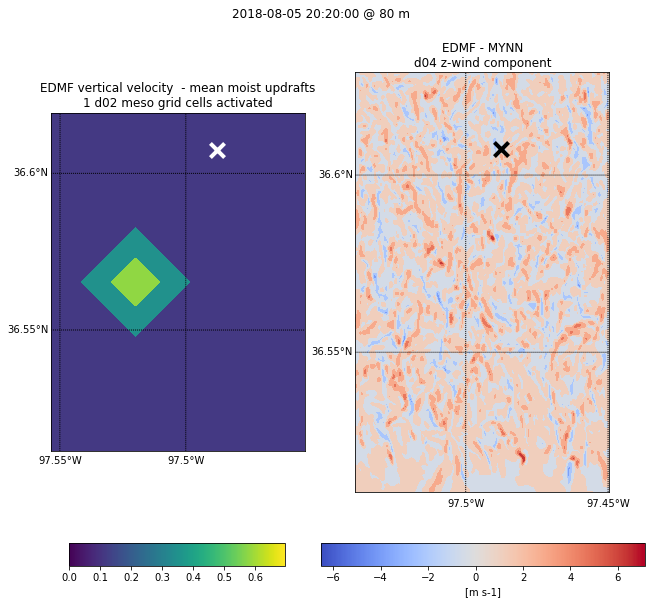

a total of 27 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20', '19:30', '19:40', '19:50', '20:0', '20:10', '20:20']


In [5]:
eval_date = '2018-08-05'
run_e = 'edmf'
run_m = 'mynn'
edmf_var = 'EDMF_W'
# d04var = 'W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04_wdiff(eval_date, run_e, run_m, edmf_var, hgt_i)

In [80]:
date_col = data_dir_df[eval_date]
file = wrf_runs_dir+date_col[run_e]+'/auxout/mmc_d04_'+eval_date+'_'+str(20)+':00:00'
wrf_single = Dataset(file, 'r')
var_e = wrf.getvar(wrf_single, 'QCLOUD', timeidx=wrf.ALL_TIMES)

In [72]:
wrf_single

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2018-08-05_12:00:00
    WEST-EAST_GRID_DIMENSION: 201
    SOUTH-NORTH_GRID_DIMENSION: 331
    BOTTOM-TOP_GRID_DIMENSION: 109
    DX: 40.0
    DY: 40.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    GRIDTYPE: C
    DIFF_OPT: 2
    KM_OPT: 2
    DAMP_OPT: 3
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 28
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 5
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 0
    CU_PHYSICS: 0
    SF_LAKE_PHYSICS: 0
    USE_BATHYMETRY: 0
    SURFACE_INPUT_SOURCE: 3
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
    GFDDA_END_H: 0
    GRID_SFDDA: 0
    SGFDDA_INTERVAL_M: 0
    SGFDDA_END_H: 0
    HYPSOMETRIC_OPT: 2
    US

In [81]:
var_e[0, 0, :, :]

<xarray.DataArray 'QCLOUD' (south_north: 330, west_east: 200)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.54 -97.54 ... -97.45 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.63 36.63
    XTIME    float32 1.92e+03
    Time     datetime64[ns] 2018-08-05T20:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  Cloud water mixing ratio
    units:        kg kg-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [33]:
'bottom_top_stag' in list(var_e.dims)

True

In [77]:
def detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i):

    # eval_date = '2018-09-01'
    # run = 'edmf'

    date_col = data_dir_df[eval_date]

    # hr = 20
    activation_t = 0
    tstamp_list = []

    for ind, hr in enumerate(np.arange(16, 24, 1)): 

        file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')

        var = wrf.getvar(wrf_single, edmf_var, timeidx=wrf.ALL_TIMES)

        # d04 grid cells in d02
        var_w = var[:, :, 121:126, 119:123]

    #     print(hr,'UTC')

        for t in np.arange(0, 6): 

            if (var_w[t, hgt_i, :, :] != 0).sum().values != 0:
                
                activation_t += 1

#                 hgt_i = 16

    #             print(var_w[t, :, :, :].Time.values)
    #             print((var_w[t, hgt_i, :, :] != 0).sum().values)

                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
                height_str = str(int(height.values))

    #             print(height_str)

                lats, lons = wrf.latlon_coords(var_w)

                fig, ax = plt.subplots()#figsize=(8, 8))

                var_1time1hgt = var_w[t, hgt_i, :, :]

                bm = wrf.get_basemap(var_1time1hgt, ax=ax)

                bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

                p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                levels=len(np.unique(var_1time1hgt.values)))

    #             print(np.unique(var_1time1hgt.values))
                tstamp = pd.Timestamp(var_w[t, :, :, :].Time.values)
                tstamp_list.append(str(tstamp.hour)+':'+str(tstamp.minute))

                ax.set_title(str(tstamp)+'\n'+var_1time1hgt.description+' @ '+height_str+' m\n'
                             +str((var_w[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

                c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax)

                c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
                ax.annotate('C1', xy=(c1x, c1y), size=15, color='white')

                cax = plt.axes([0.25, 0.01, 0.5, 0.04])
                sm = plt.cm.ScalarMappable(cmap='viridis', 
                                           norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                plt.show()
                
    print('a total of', activation_t, 'time steps w/ EDMF turned on in d02, they are:')
    print(tstamp_list)

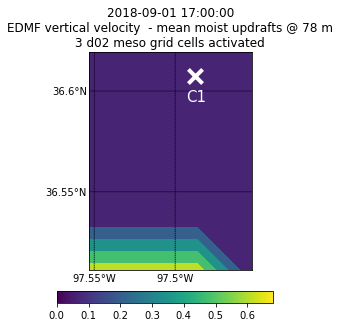

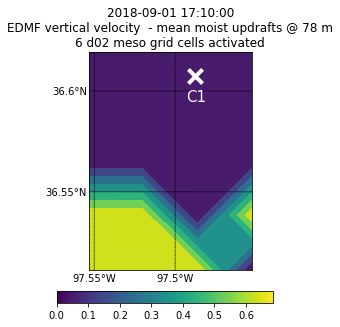

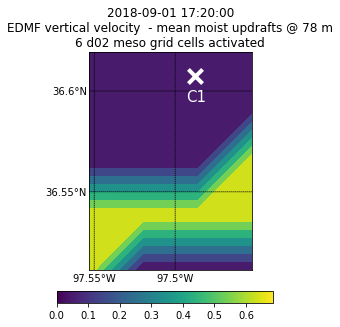

a total of 3 time steps w/ EDMF turned on in d02, they are:
['17:0', '17:10', '17:20']


In [78]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

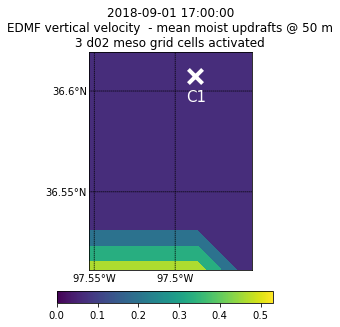

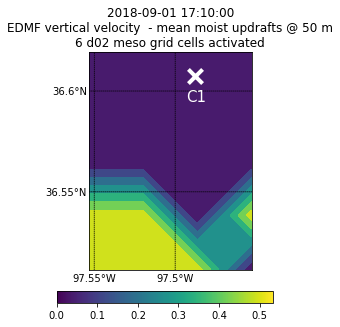

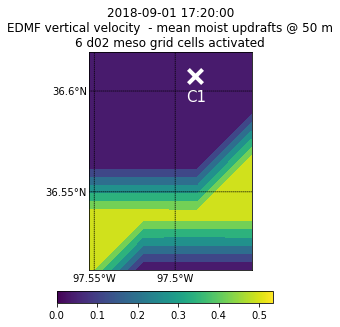

a total of 3 time steps w/ EDMF turned on in d02


In [62]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 10

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

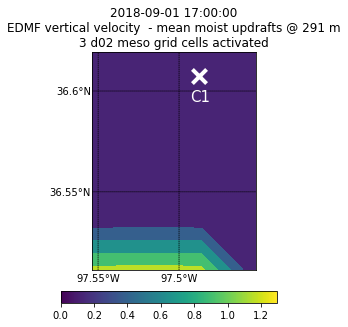

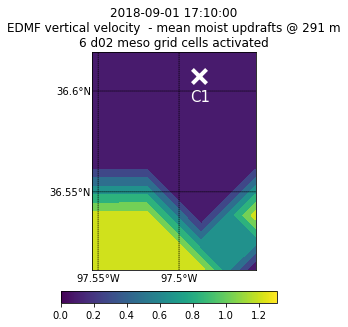

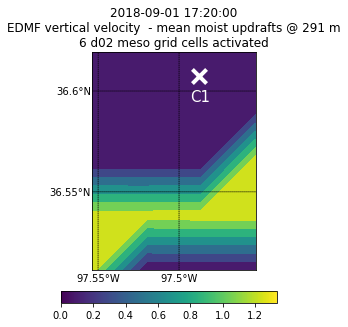

a total of 3 time steps w/ EDMF turned on in d02


In [64]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 40

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

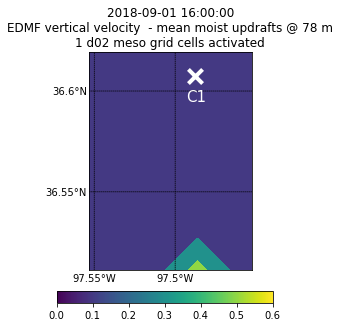

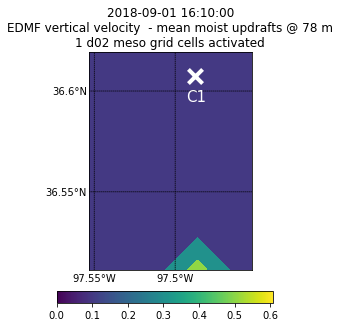

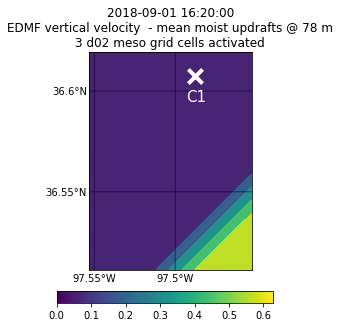

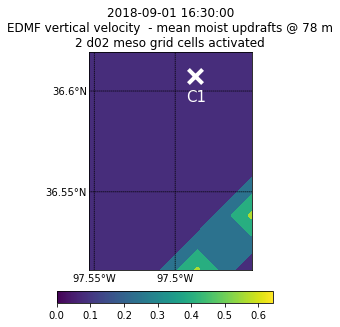

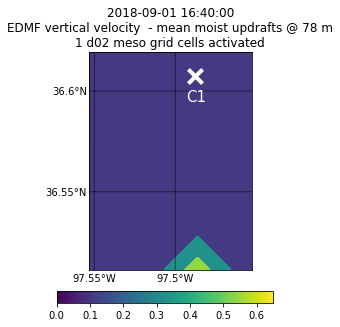

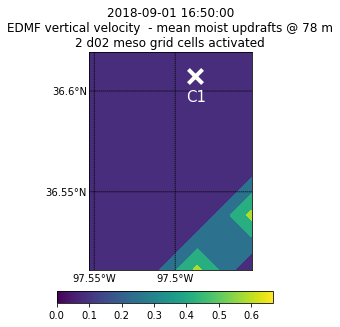

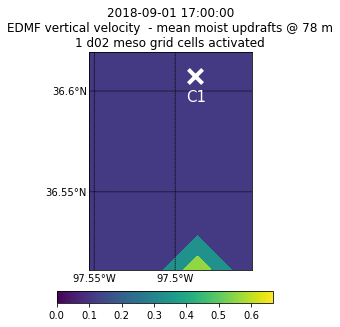

a total of 7 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0']


In [81]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

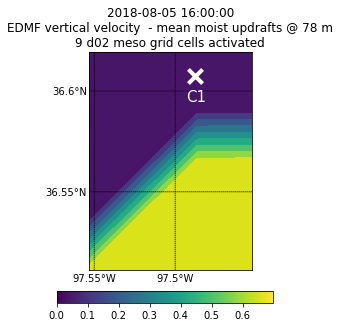

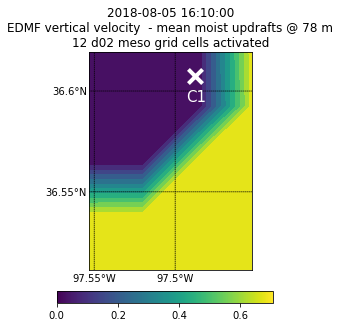

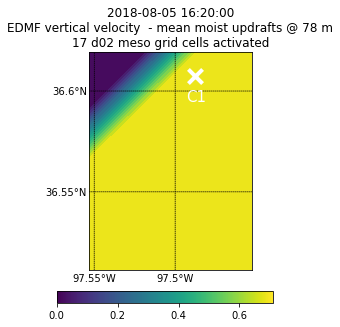

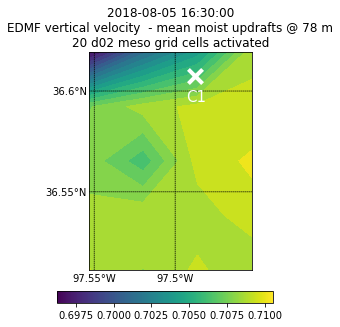

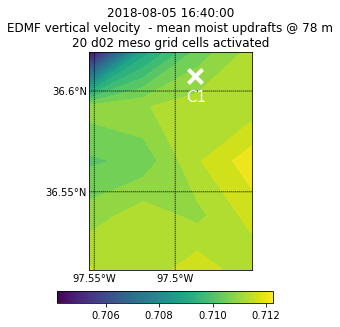

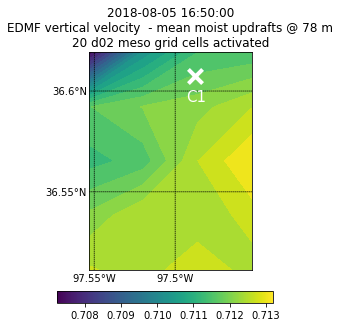

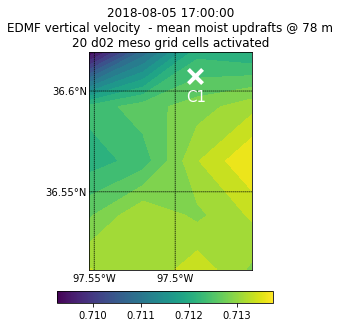

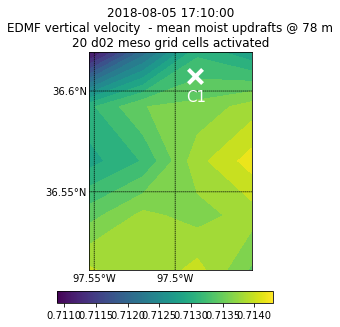

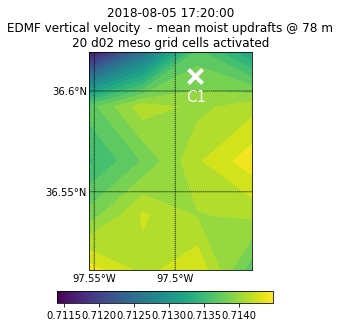

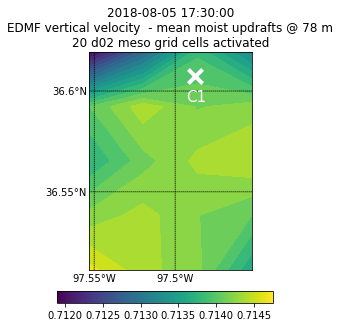

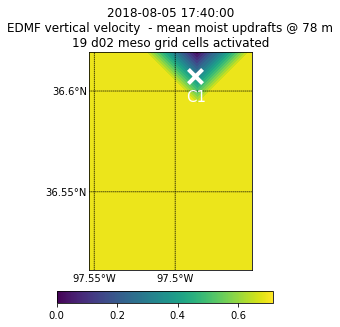

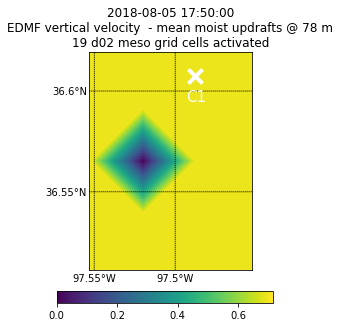

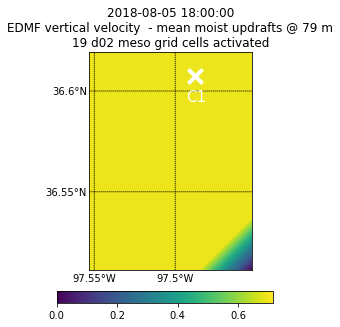

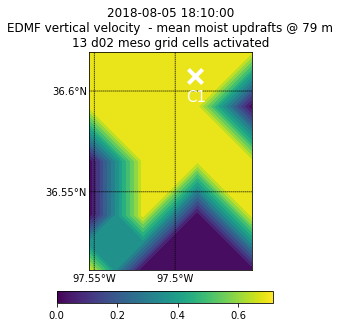

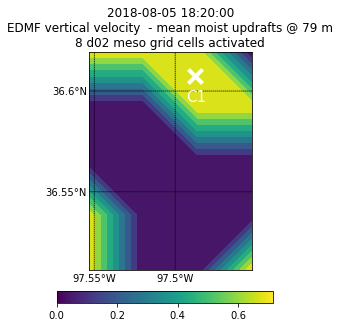

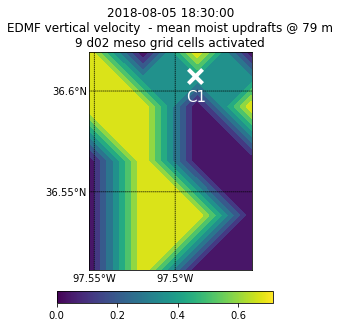

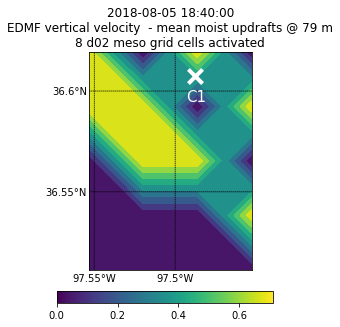

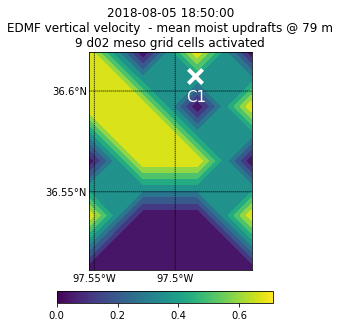

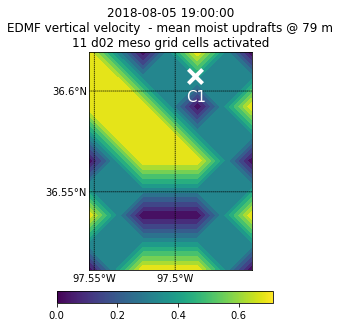

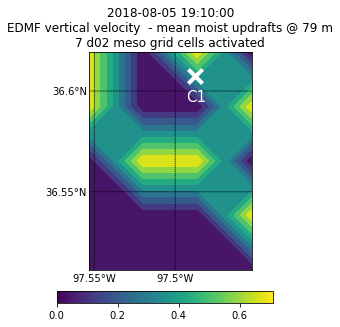

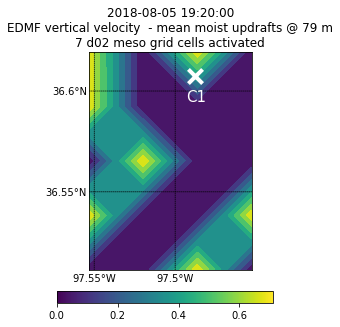

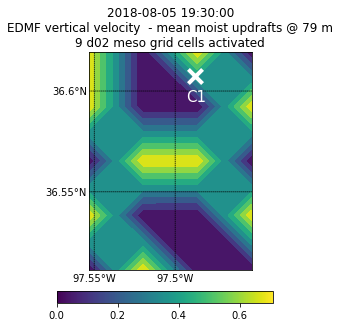

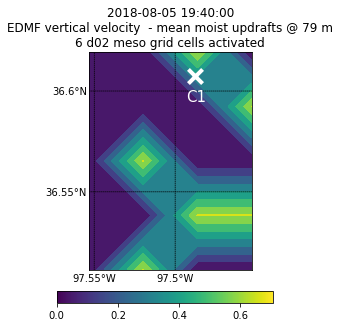

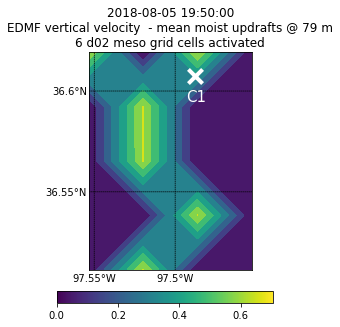

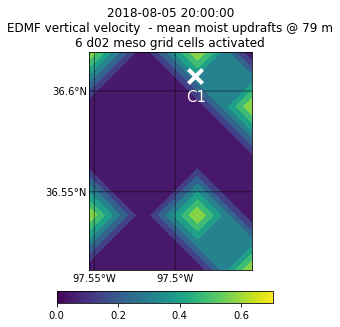

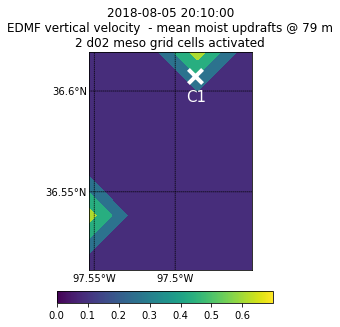

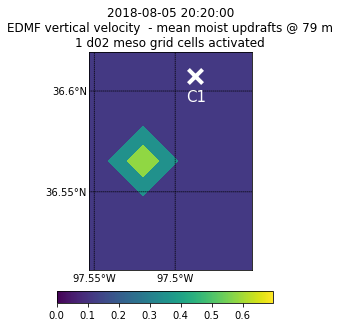

a total of 27 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20', '19:30', '19:40', '19:50', '20:0', '20:10', '20:20']


In [79]:
eval_date = '2018-08-05'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

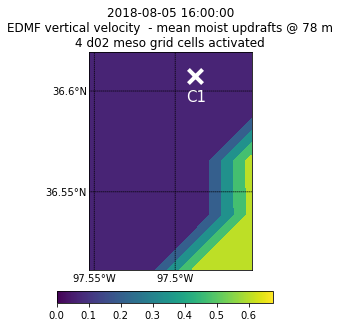

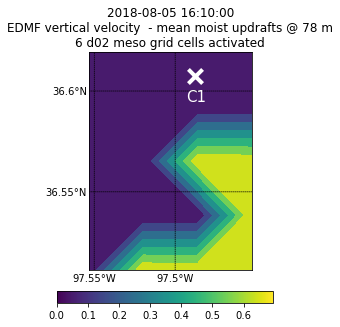

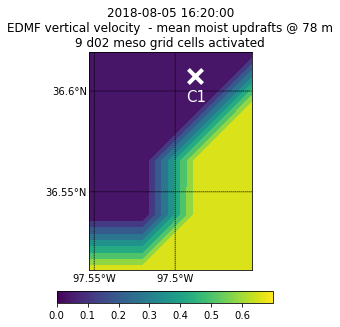

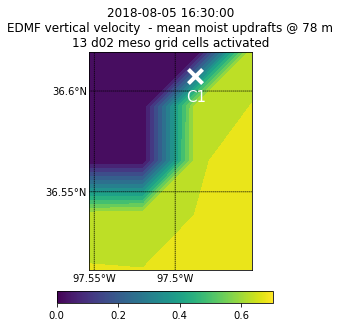

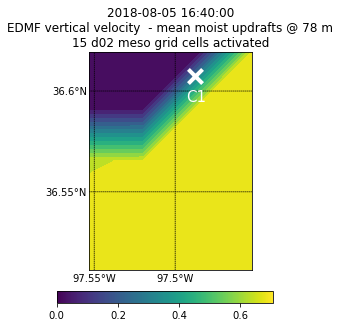

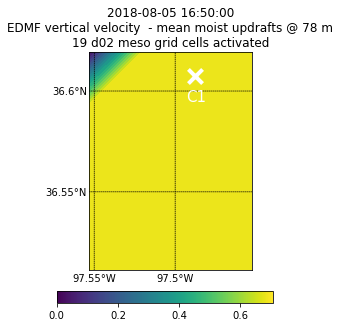

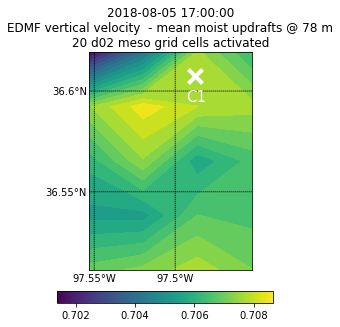

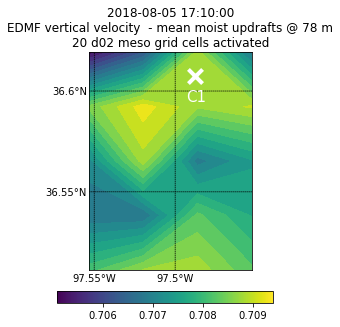

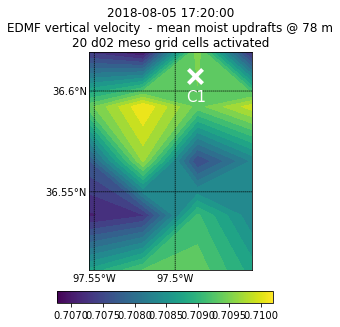

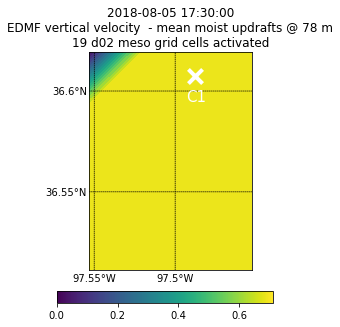

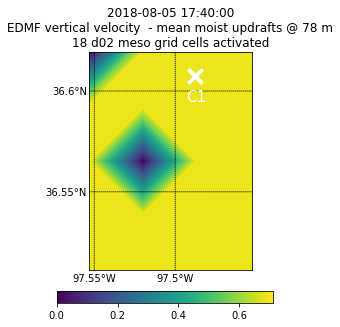

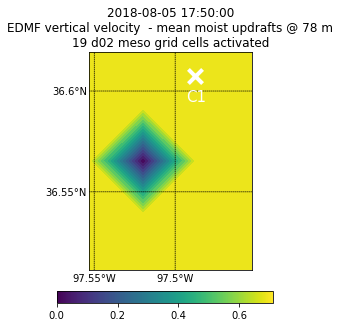

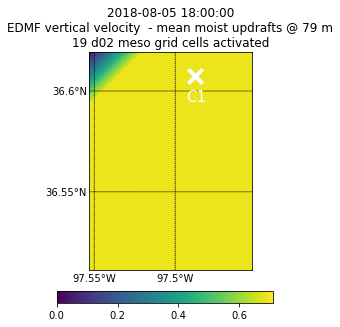

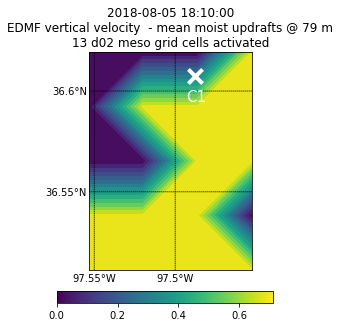

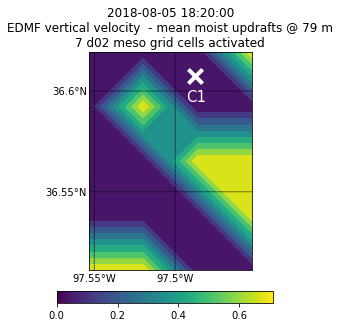

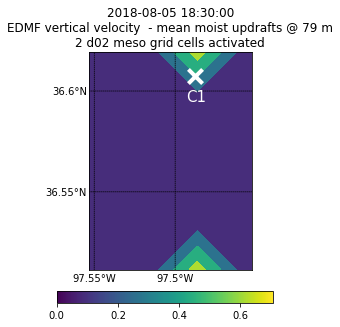

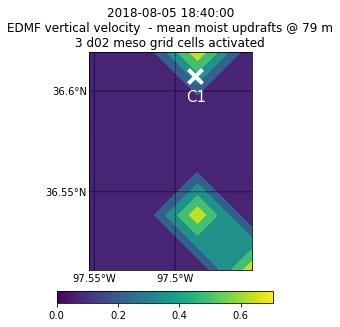

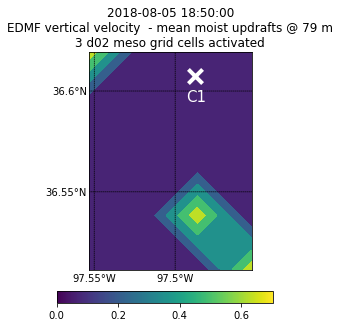

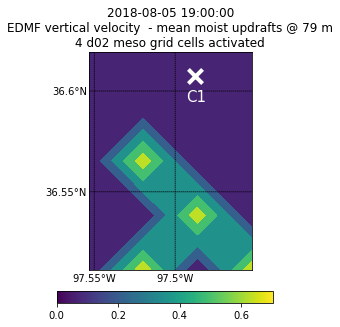

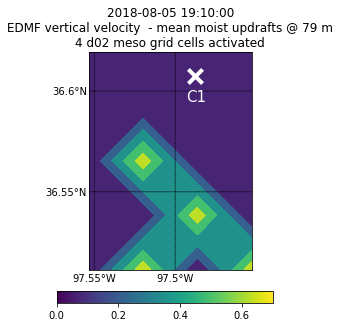

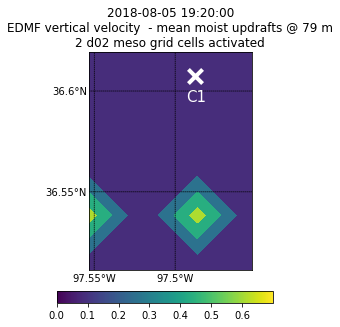

a total of 21 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20']


In [80]:
eval_date = '2018-08-05'
run = 'edmf_d12-9s_d34-1s'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

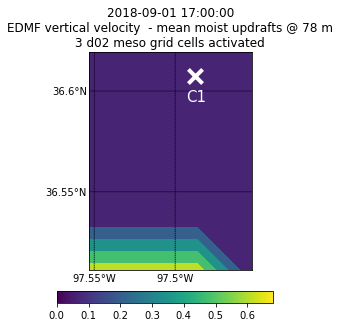

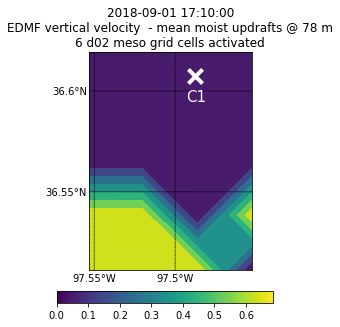

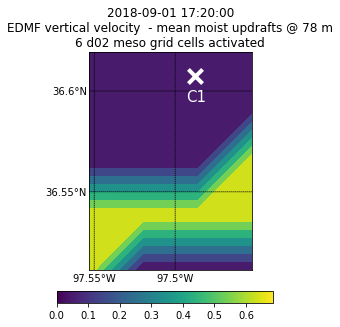

In [40]:
eval_date = '2018-09-01'
run = 'edmf'

date_col = data_dir_df[eval_date]
    
# hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_W', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
#     print(hr,'UTC')
    
    for t in np.arange(0, 6): 
        
        if (var_w[t, 16, :, :] != 0).sum().values != 0:
            
            hgt_i = 16
            
#             print(var_w[t, :, :, :].Time.values)
#             print((var_w[t, hgt_i, :, :] != 0).sum().values)
            
            height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
            height_str = str(int(height.values))
            
#             print(height_str)
            
            lats, lons = wrf.latlon_coords(var_w)

            fig, ax = plt.subplots()#figsize=(8, 8))
            
            var_1time1hgt = var_w[t, 16, :, :]
            
            bm = wrf.get_basemap(var_1time1hgt, ax=ax)

            bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
            bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

            x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

            p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                            levels=len(np.unique(var_1time1hgt.values)))
            
#             print(np.unique(var_1time1hgt.values))

            ax.set_title(str(pd.Timestamp(var_w[t, :, :, :].Time.values))+'\n'
                         +var_1time1hgt.description+' @ '+height_str+' m\n'
                         +str((var_w[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

            c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
            bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax)

            c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            ax.annotate('C1', xy=(c1x, c1y), size=15, color='white')
            
            cax = plt.axes([0.25, 0.01, 0.5, 0.04])
            sm = plt.cm.ScalarMappable(cmap='viridis', 
                                       norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
            cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
            
            plt.show()

In [23]:
var_1time

<xarray.DataArray 'EDMF_A' (south_north: 5, west_east: 4)>
array([[0.09847245, 0.        , 0.        , 0.        ],
       [0.09844768, 0.09846354, 0.09834101, 0.09849194],
       [0.        , 0.        , 0.        , 0.09847614],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.55 -97.52 ... -97.49 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.62 36.62
    XTIME    float32 1.76e+03
    Time     datetime64[ns] 2018-09-01T17:20:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF relative updraft  area - moist updrafts
    units:        -
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [16]:
str(pd.Timestamp(var_w[t, :, :, :].Time.values))

'2018-09-01 17:00:00'

In [5]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_W', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
#     print(hr,'UTC')
    
    for t in np.arange(0, 6): 
        if (var_w[t, 16, :, :] != 0).sum().values != 0:
            print(var_w[t, :, :, :].Time.values)
            print((var_w[t, 16, :, :] != 0).sum().values)

2018-09-01T16:00:00.000000000
1
2018-09-01T16:10:00.000000000
1
2018-09-01T16:20:00.000000000
3
2018-09-01T16:30:00.000000000
2
2018-09-01T16:40:00.000000000
1
2018-09-01T16:50:00.000000000
2
2018-09-01T17:00:00.000000000
1


In [199]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_A', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
    print(hr,'UTC')
    print((var_w[:, 20, :, :] != 0).sum().values)

16 UTC
10
17 UTC
1
18 UTC
0
19 UTC
0
20 UTC
0
21 UTC
0
22 UTC
0
23 UTC
0


In [197]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_A', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
    print(hr,'UTC')
    print((var_w[:, 16, :, :] != 0).sum().values)

16 UTC
10
17 UTC
1
18 UTC
0
19 UTC
0
20 UTC
0
21 UTC
0
22 UTC
0
23 UTC
0


In [205]:
var_w[1, :, :, :].Time.values

numpy.datetime64('2018-09-01T23:10:00.000000000')

In [22]:
var.XLAT[115:133, :]

<xarray.DataArray 'XLAT' (south_north: 18, west_east: 220)>
array([[36.28063 , 36.28176 , 36.28287 , ..., 36.306057, 36.305145,
        36.30422 ],
       [36.307575, 36.308716, 36.309837, ..., 36.33302 , 36.33212 ,
        36.331192],
       [36.334534, 36.33567 , 36.3368  , ..., 36.35998 , 36.359074,
        36.358162],
       ...,
       [36.68502 , 36.68616 , 36.687286, ..., 36.71058 , 36.709663,
        36.70874 ],
       [36.71198 , 36.71311 , 36.714245, ..., 36.737553, 36.736637,
        36.735714],
       [36.738937, 36.740078, 36.741203, ..., 36.76451 , 36.7636  ,
        36.762676]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.5 -101.5 ... -94.22 -94.18
    XLAT     (south_north, west_east) float32 36.28 36.28 36.28 ... 36.76 36.76
Dimensions without coordinates: south_north, west_east

In [8]:
var

<xarray.DataArray 'EDMF_W' (Time: 6, bottom_top: 108, south_north: 220, west_east: 220)>
array([[[[0.        , 0.        , 0.24901947, ..., 0.        ,
          0.        , 0.        ],
         [0.24901946, 0.24901944, 0.        , ..., 0.        ,
          0.21707347, 0.        ],
         [0.24901947, 0.24901947, 0.24901946, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.24901944, ..., 0.        ,
          0.        , 0.        ],
         [0.06113675, 0.07132042, 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.27806658, ..., 0.        ,
          0.        , 0.        ],
         [0.2778025 , 0.27746004, 0.        , ..., 0.        ,
          0.24092576, 0.        ],
         [0.27774593, 0.27741912, 0.2776133 , ..., 0.        ,
          0.        , 0.        ],
...
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    (Time) float32 1.8e+03 1.81e+03 1.82e+03 1.83e+03 1.84e+03 1.85e+03
  * Time     (Time) datetime64[ns] 2018-09-01T18:00:00 ... 2018-09-01T18:50:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF vertical velocity  - mean moist updrafts
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [9]:
filed4 = wrf_runs_dir+date_col[run]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':00:00'
wrf_singled4 = Dataset(filed4, 'r')

In [11]:
hfxd4 = wrf.getvar(wrf_singled4, 'HFX', timeidx=wrf.ALL_TIMES)

In [15]:
hfxd4.XLAT.max(), hfxd4.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.62898254),
 <xarray.DataArray 'XLAT' ()>
 array(36.51060104))

In [16]:
hfxd4.XLONG.max(), hfxd4.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.44958496),
 <xarray.DataArray 'XLONG' ()>
 array(-97.53878784))

In [91]:
filed3 = wrf_runs_dir+date_col[run]+'/auxout/mmc_d03_'+eval_date+'_'+str(hr)+':00:00'
wrf_singled3 = Dataset(filed3, 'r')

hfxd3 = wrf.getvar(wrf_singled3, 'HFX', timeidx=wrf.ALL_TIMES)[:, 158:223, 89:129]

In [92]:
hfxd3.XLAT.max(), hfxd3.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.6282692),
 <xarray.DataArray 'XLAT' ()>
 array(36.51312256))

In [93]:
hfxd3.XLONG.max(), hfxd3.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45046997),
 <xarray.DataArray 'XLONG' ()>
 array(-97.53787231))

In [134]:
var_w = var[:, :, 122:126, 119:123]

In [135]:
var_w.XLAT.max(), var_w.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.61926651),
 <xarray.DataArray 'XLAT' ()>
 array(36.53829193))

In [136]:
var_w.XLONG.max(), var_w.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45269775),
 <xarray.DataArray 'XLONG' ()>
 array(-97.55358887))

In [165]:
var_w = var[:, :, 121:126, 119:123]

In [166]:
var_w.XLAT.max(), var_w.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.61926651),
 <xarray.DataArray 'XLAT' ()>
 array(36.51131058))

In [167]:
var_w.XLONG.max(), var_w.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45269775),
 <xarray.DataArray 'XLONG' ()>
 array(-97.55358887))

In [169]:
var_w[:, 0, :, :]

<xarray.DataArray 'EDMF_W' (Time: 6, south_north: 5, west_east: 4)>
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.55 -97.52 ... -97.49 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.62 36.62
    XTIME    (Time) float32 1.8e+03 1.81e+03 1.82e+03 1.83e+03 1.84e+03 1.85e+03
  * Time     (Time) datetime64[ns] 2018-09-01T18:00:00 ... 2018-09-01T18:50:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF vertical velocity  - mean moist updrafts
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...